In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-17 22:16:25.091301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import re

In [3]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [4]:
datapath = "../../../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [5]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [6]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [7]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [8]:
def prepare_data(features):
    sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
    scaler = StandardScaler()
    features_scaled = features.copy()
    features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])
    features_scaled = features_scaled[sensor_columns + ['activity']]
    
    print ("columns : ", features_scaled.columns)
    adl_count = features_scaled['activity'].value_counts()[0]
    fall_count = features_scaled['activity'].value_counts()[1]

    adl_mask = features_scaled['activity'] == 0
    adl_data = features_scaled[adl_mask]
    adl1 = adl_data.iloc[:int(adl_count * 0.8)]
    adl2 = adl_data.iloc[int(adl_count * 0.2):]

    fall_mask = features_scaled['activity'] == 1
    fall_data = features_scaled[fall_mask]
    fall1 = fall_data.iloc[:int(fall_count * 0.8)]
    fall2 = fall_data.iloc[int(fall_count * 0.2):]
    
    train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)
    test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
    test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
    test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)
    
    return train_data, test_adl_data, test_fall1_data, test_fall2_data

In [9]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [10]:
subject_id = 16
dfs_16 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_16.append(df)

features_16 = pd.concat(dfs_16, ignore_index=True)
features_16['activity'] = features_16['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_16 = features_16.dropna()

100%|█████████████████████████████████████████| 746/746 [00:00<00:00, 1303.92it/s]


In [11]:
subject_id = 17
dfs_17 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_17.append(df)

features_17 = pd.concat(dfs_17, ignore_index=True)
features_17['activity'] = features_17['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_17 = features_17.dropna()

100%|█████████████████████████████████████████| 746/746 [00:00<00:00, 1309.96it/s]


In [12]:
subject_id = 18
dfs_18 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_18.append(df)

features_18 = pd.concat(dfs_18, ignore_index=True)
features_18['activity'] = features_18['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_18 = features_18.dropna()

100%|██████████████████████████████████████████| 746/746 [00:05<00:00, 148.84it/s]


In [13]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data_16, test_adl_data_16, test_fall1_data_16, test_fall2_data_16 = prepare_data(features_16)
train_data_17, test_adl_data_17, test_fall1_data_17, test_fall2_data_17 = prepare_data(features_17)
train_data_18, test_adl_data_18, test_fall1_data_18, test_fall2_data_18 = prepare_data(features_18)

columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')
columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_

----

In [14]:
EPOCHS = 300
INITIAL_LEARNING_RATE = 1e-3  
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [15]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [18]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=39):
        super(UNet1D, self).__init__()
        
        # Sinusoidal time embeddings
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2, padding=0)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(2, padding=0)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(2, padding=0)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Time feature projection
        self.time_mlp = nn.Linear(64, 512)
        
        # Decoder with output padding to match encoder sizes
        self.upconv3 = nn.ConvTranspose1d(512, 256, 2, stride=2, output_padding=0)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose1d(256, 128, 2, stride=2, output_padding=0)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose1d(128, 64, 2, stride=2, output_padding=0)
        self.dec1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv1d(64, in_channels, 1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = self.time_mlp(t_emb)
        
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        # Bottleneck with time embedding
        b = self.bottleneck(p3)
        b = b + t_emb.unsqueeze(-1)
        
        # Decoder with size adjustment if needed
        d3 = self.upconv3(b)
        if d3.shape[-1] != e3.shape[-1]:
            d3 = F.interpolate(d3, size=e3.shape[-1], mode='linear')
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        if d2.shape[-1] != e2.shape[-1]:
            d2 = F.interpolate(d2, size=e2.shape[-1], mode='linear')
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        if d1.shape[-1] != e1.shape[-1]:
            d1 = F.interpolate(d1, size=e1.shape[-1], mode='linear')
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final_conv(d1)

In [19]:
class DDPM:
    def __init__(self, num_timesteps=100, beta_start=1e-4, beta_end=0.02):
        """
        num_timesteps: total diffusion steps T
        beta_start, beta_end: β₁ and βₜ for linear schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [20]:
class DDPM_ELBO(DDPM):
    def __init__(self, num_timesteps=100, beta_start=1e-4, beta_end=0.02):
        super().__init__(num_timesteps, beta_start, beta_end)
        
    def compute_elbo(self, model, x_0, t):
        """
        Compute ELBO (Evidence Lower BOund) for anomaly detection
        """
        x_t, epsilon = self.q_sample(x_0, t)
        epsilon_theta = model(x_t, t)
        
        # Compute KL divergence term
        kl_div = F.mse_loss(epsilon_theta, epsilon, reduction='none')
        kl_div = kl_div.mean(dim=(1, 2))
        
        # Compute reconstruction term
        alpha_t = self.alphas_cumprod[t][:, None, None]
        sigma_t = torch.sqrt(1 - alpha_t)
        
        mean = x_0 * torch.sqrt(alpha_t) + epsilon_theta * sigma_t
        reconstruction_loss = F.mse_loss(x_t, mean, reduction='none')
        reconstruction_loss = reconstruction_loss.mean(dim=(1, 2))
        
        # Total ELBO loss
        elbo = kl_div + reconstruction_loss
        return elbo

In [21]:
# def train_ddpm(model, train_loader, ddpm, optimizer, num_epochs, device):
#     model.train()
    
#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         n_batches = len(train_loader)
        
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
#             # batch is already [batch, features, window_length]
#             x_0 = batch.to(device)
#             batch_size = x_0.shape[0]
            
#             optimizer.zero_grad()
#             t = ddpm.sample_t(batch_size).to(device)
#             x_t, epsilon = ddpm.q_sample(x_0, t)
#             epsilon_theta = model(x_t, t)
#             loss = F.mse_loss(epsilon_theta, epsilon)
#             loss.backward()
#             optimizer.step()
            
#             epoch_loss += loss.item()
        
#         avg_loss = epoch_loss / n_batches
#         print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [31]:
def train_ddpm_elbo(model, train_loader, ddpm, scheduler, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            
            # Compute ELBO loss
            elbo_loss = ddpm.compute_elbo(model, x_0, t)
            loss = elbo_loss.mean()
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        scheduler.step()  
        print(f'Epoch {epoch+1}/{num_epochs} - Avg ELBO Loss: {avg_loss:.4f}')

In [34]:
model1 = UNet1D().to(device)
ddpm1 = DDPM_ELBO(num_timesteps=1000)
optimizer1 = optim.AdamW(
    model1.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)
scheduler1 = optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=EPOCHS)

print("\nSubject 16 Training:")
train_dataset_16 = UMAFallDataset(train_data_16)
train_loader_16 = DataLoader(train_dataset_16, batch_size=BATCH_SIZE)
train_ddpm_elbo(model1, train_loader_16, ddpm1, scheduler1, optimizer1, EPOCHS, device)


Subject 16 Training:


Epoch 1/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 13.64it/s]


Epoch 1/300 - Avg ELBO Loss: 1.6991


Epoch 2/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch 2/300 - Avg ELBO Loss: 1.7864


Epoch 3/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 17.67it/s]


Epoch 3/300 - Avg ELBO Loss: 1.7170


Epoch 4/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 16.31it/s]


Epoch 4/300 - Avg ELBO Loss: 1.6232


Epoch 5/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 15.15it/s]


Epoch 5/300 - Avg ELBO Loss: 1.6479


Epoch 6/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 15.73it/s]


Epoch 6/300 - Avg ELBO Loss: 1.7452


Epoch 7/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 16.45it/s]


Epoch 7/300 - Avg ELBO Loss: 1.6817


Epoch 8/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 15.24it/s]


Epoch 8/300 - Avg ELBO Loss: 1.7671


Epoch 9/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 13.56it/s]


Epoch 9/300 - Avg ELBO Loss: 1.8225


Epoch 10/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]


Epoch 10/300 - Avg ELBO Loss: 1.6904


Epoch 11/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.86it/s]


Epoch 11/300 - Avg ELBO Loss: 1.7062


Epoch 12/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.77it/s]


Epoch 12/300 - Avg ELBO Loss: 1.7128


Epoch 13/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.10it/s]


Epoch 13/300 - Avg ELBO Loss: 1.6811


Epoch 14/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.76it/s]


Epoch 14/300 - Avg ELBO Loss: 1.6190


Epoch 15/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.42it/s]


Epoch 15/300 - Avg ELBO Loss: 1.6082


Epoch 16/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.78it/s]


Epoch 16/300 - Avg ELBO Loss: 1.5436


Epoch 17/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.78it/s]


Epoch 17/300 - Avg ELBO Loss: 1.6230


Epoch 18/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.75it/s]


Epoch 18/300 - Avg ELBO Loss: 1.6080


Epoch 19/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.42it/s]


Epoch 19/300 - Avg ELBO Loss: 1.5628


Epoch 20/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.79it/s]


Epoch 20/300 - Avg ELBO Loss: 1.5729


Epoch 21/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.20it/s]


Epoch 21/300 - Avg ELBO Loss: 1.5179


Epoch 22/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 22/300 - Avg ELBO Loss: 1.4344


Epoch 23/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.16it/s]


Epoch 23/300 - Avg ELBO Loss: 1.4822


Epoch 24/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


Epoch 24/300 - Avg ELBO Loss: 1.5398


Epoch 25/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.57it/s]


Epoch 25/300 - Avg ELBO Loss: 1.4309


Epoch 26/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.95it/s]


Epoch 26/300 - Avg ELBO Loss: 1.4712


Epoch 27/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.38it/s]


Epoch 27/300 - Avg ELBO Loss: 1.4620


Epoch 28/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.62it/s]


Epoch 28/300 - Avg ELBO Loss: 1.4372


Epoch 29/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch 29/300 - Avg ELBO Loss: 1.4519


Epoch 30/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.95it/s]


Epoch 30/300 - Avg ELBO Loss: 1.4349


Epoch 31/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.78it/s]


Epoch 31/300 - Avg ELBO Loss: 1.3919


Epoch 32/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.71it/s]


Epoch 32/300 - Avg ELBO Loss: 1.3850


Epoch 33/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.64it/s]


Epoch 33/300 - Avg ELBO Loss: 1.3612


Epoch 34/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.28it/s]


Epoch 34/300 - Avg ELBO Loss: 1.3819


Epoch 35/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 35/300 - Avg ELBO Loss: 1.3747


Epoch 36/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.50it/s]


Epoch 36/300 - Avg ELBO Loss: 1.4005


Epoch 37/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.71it/s]


Epoch 37/300 - Avg ELBO Loss: 1.3166


Epoch 38/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.41it/s]


Epoch 38/300 - Avg ELBO Loss: 1.3142


Epoch 39/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 11.26it/s]


Epoch 39/300 - Avg ELBO Loss: 1.3148


Epoch 40/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.40it/s]


Epoch 40/300 - Avg ELBO Loss: 1.3178


Epoch 41/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.29it/s]


Epoch 41/300 - Avg ELBO Loss: 1.3729


Epoch 42/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 42/300 - Avg ELBO Loss: 1.2841


Epoch 43/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


Epoch 43/300 - Avg ELBO Loss: 1.2739


Epoch 44/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.14it/s]


Epoch 44/300 - Avg ELBO Loss: 1.2863


Epoch 45/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 45/300 - Avg ELBO Loss: 1.2400


Epoch 46/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.30it/s]


Epoch 46/300 - Avg ELBO Loss: 1.3097


Epoch 47/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.46it/s]


Epoch 47/300 - Avg ELBO Loss: 1.2668


Epoch 48/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.82it/s]


Epoch 48/300 - Avg ELBO Loss: 1.2864


Epoch 49/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.01it/s]


Epoch 49/300 - Avg ELBO Loss: 1.2307


Epoch 50/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.28it/s]


Epoch 50/300 - Avg ELBO Loss: 1.2088


Epoch 51/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 19.05it/s]


Epoch 51/300 - Avg ELBO Loss: 1.2326


Epoch 52/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.02it/s]


Epoch 52/300 - Avg ELBO Loss: 1.2327


Epoch 53/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.45it/s]


Epoch 53/300 - Avg ELBO Loss: 1.2238


Epoch 54/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.42it/s]


Epoch 54/300 - Avg ELBO Loss: 1.2175


Epoch 55/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.97it/s]


Epoch 55/300 - Avg ELBO Loss: 1.2272


Epoch 56/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.28it/s]


Epoch 56/300 - Avg ELBO Loss: 1.2426


Epoch 57/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.47it/s]


Epoch 57/300 - Avg ELBO Loss: 1.2139


Epoch 58/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.51it/s]


Epoch 58/300 - Avg ELBO Loss: 1.2119


Epoch 59/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.76it/s]


Epoch 59/300 - Avg ELBO Loss: 1.1985


Epoch 60/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.65it/s]


Epoch 60/300 - Avg ELBO Loss: 1.2106


Epoch 61/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.98it/s]


Epoch 61/300 - Avg ELBO Loss: 1.1730


Epoch 62/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.84it/s]


Epoch 62/300 - Avg ELBO Loss: 1.2009


Epoch 63/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.55it/s]


Epoch 63/300 - Avg ELBO Loss: 1.1787


Epoch 64/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]


Epoch 64/300 - Avg ELBO Loss: 1.1819


Epoch 65/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.89it/s]


Epoch 65/300 - Avg ELBO Loss: 1.1546


Epoch 66/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.51it/s]


Epoch 66/300 - Avg ELBO Loss: 1.1651


Epoch 67/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.91it/s]


Epoch 67/300 - Avg ELBO Loss: 1.1653


Epoch 68/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.40it/s]


Epoch 68/300 - Avg ELBO Loss: 1.1335


Epoch 69/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.08it/s]


Epoch 69/300 - Avg ELBO Loss: 1.2001


Epoch 70/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.83it/s]


Epoch 70/300 - Avg ELBO Loss: 1.1316


Epoch 71/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.69it/s]


Epoch 71/300 - Avg ELBO Loss: 1.1594


Epoch 72/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.42it/s]


Epoch 72/300 - Avg ELBO Loss: 1.1451


Epoch 73/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.15it/s]


Epoch 73/300 - Avg ELBO Loss: 1.1437


Epoch 74/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.94it/s]


Epoch 74/300 - Avg ELBO Loss: 1.1747


Epoch 75/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.41it/s]


Epoch 75/300 - Avg ELBO Loss: 1.1631


Epoch 76/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.30it/s]


Epoch 76/300 - Avg ELBO Loss: 1.1189


Epoch 77/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.53it/s]


Epoch 77/300 - Avg ELBO Loss: 1.1302


Epoch 78/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.27it/s]


Epoch 78/300 - Avg ELBO Loss: 1.1004


Epoch 79/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.90it/s]


Epoch 79/300 - Avg ELBO Loss: 1.1373


Epoch 80/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.69it/s]


Epoch 80/300 - Avg ELBO Loss: 1.1102


Epoch 81/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.54it/s]


Epoch 81/300 - Avg ELBO Loss: 1.1135


Epoch 82/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.13it/s]


Epoch 82/300 - Avg ELBO Loss: 1.0836


Epoch 83/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.72it/s]


Epoch 83/300 - Avg ELBO Loss: 1.1204


Epoch 84/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.77it/s]


Epoch 84/300 - Avg ELBO Loss: 1.0959


Epoch 85/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


Epoch 85/300 - Avg ELBO Loss: 1.1224


Epoch 86/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


Epoch 86/300 - Avg ELBO Loss: 1.1207


Epoch 87/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.71it/s]


Epoch 87/300 - Avg ELBO Loss: 1.1112


Epoch 88/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.32it/s]


Epoch 88/300 - Avg ELBO Loss: 1.1189


Epoch 89/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.44it/s]


Epoch 89/300 - Avg ELBO Loss: 1.0870


Epoch 90/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.47it/s]


Epoch 90/300 - Avg ELBO Loss: 1.0691


Epoch 91/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.34it/s]


Epoch 91/300 - Avg ELBO Loss: 1.0594


Epoch 92/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.75it/s]


Epoch 92/300 - Avg ELBO Loss: 1.0823


Epoch 93/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.01it/s]


Epoch 93/300 - Avg ELBO Loss: 1.0839


Epoch 94/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.57it/s]


Epoch 94/300 - Avg ELBO Loss: 1.0447


Epoch 95/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.96it/s]


Epoch 95/300 - Avg ELBO Loss: 1.0815


Epoch 96/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.50it/s]


Epoch 96/300 - Avg ELBO Loss: 1.0980


Epoch 97/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.25it/s]


Epoch 97/300 - Avg ELBO Loss: 1.0603


Epoch 98/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.40it/s]


Epoch 98/300 - Avg ELBO Loss: 1.0922


Epoch 99/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.65it/s]


Epoch 99/300 - Avg ELBO Loss: 1.0583


Epoch 100/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.33it/s]


Epoch 100/300 - Avg ELBO Loss: 1.0755


Epoch 101/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.31it/s]


Epoch 101/300 - Avg ELBO Loss: 1.0845


Epoch 102/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.62it/s]


Epoch 102/300 - Avg ELBO Loss: 1.0632


Epoch 103/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.46it/s]


Epoch 103/300 - Avg ELBO Loss: 1.0796


Epoch 104/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.34it/s]


Epoch 104/300 - Avg ELBO Loss: 1.0489


Epoch 105/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch 105/300 - Avg ELBO Loss: 1.0758


Epoch 106/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.42it/s]


Epoch 106/300 - Avg ELBO Loss: 1.0351


Epoch 107/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.69it/s]


Epoch 107/300 - Avg ELBO Loss: 1.0434


Epoch 108/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.13it/s]


Epoch 108/300 - Avg ELBO Loss: 1.0322


Epoch 109/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.25it/s]


Epoch 109/300 - Avg ELBO Loss: 1.0408


Epoch 110/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.73it/s]


Epoch 110/300 - Avg ELBO Loss: 1.0298


Epoch 111/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.13it/s]


Epoch 111/300 - Avg ELBO Loss: 1.0403


Epoch 112/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 112/300 - Avg ELBO Loss: 1.0188


Epoch 113/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.27it/s]


Epoch 113/300 - Avg ELBO Loss: 1.0171


Epoch 114/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]


Epoch 114/300 - Avg ELBO Loss: 1.0217


Epoch 115/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.71it/s]


Epoch 115/300 - Avg ELBO Loss: 1.0339


Epoch 116/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.03it/s]


Epoch 116/300 - Avg ELBO Loss: 1.0419


Epoch 117/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 117/300 - Avg ELBO Loss: 1.0095


Epoch 118/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 21.42it/s]


Epoch 118/300 - Avg ELBO Loss: 1.0101


Epoch 119/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.93it/s]


Epoch 119/300 - Avg ELBO Loss: 1.0219


Epoch 120/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.97it/s]


Epoch 120/300 - Avg ELBO Loss: 1.0378


Epoch 121/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.79it/s]


Epoch 121/300 - Avg ELBO Loss: 1.0097


Epoch 122/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.72it/s]


Epoch 122/300 - Avg ELBO Loss: 1.0024


Epoch 123/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]


Epoch 123/300 - Avg ELBO Loss: 1.0123


Epoch 124/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 124/300 - Avg ELBO Loss: 1.0160


Epoch 125/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.85it/s]


Epoch 125/300 - Avg ELBO Loss: 1.0252


Epoch 126/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.01it/s]


Epoch 126/300 - Avg ELBO Loss: 1.0061


Epoch 127/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.40it/s]


Epoch 127/300 - Avg ELBO Loss: 0.9925


Epoch 128/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.17it/s]


Epoch 128/300 - Avg ELBO Loss: 1.0106


Epoch 129/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 21.13it/s]


Epoch 129/300 - Avg ELBO Loss: 1.0029


Epoch 130/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 21.57it/s]


Epoch 130/300 - Avg ELBO Loss: 1.0022


Epoch 131/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.17it/s]


Epoch 131/300 - Avg ELBO Loss: 0.9833


Epoch 132/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 21.22it/s]


Epoch 132/300 - Avg ELBO Loss: 0.9985


Epoch 133/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.32it/s]


Epoch 133/300 - Avg ELBO Loss: 0.9790


Epoch 134/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.81it/s]


Epoch 134/300 - Avg ELBO Loss: 0.9752


Epoch 135/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.86it/s]


Epoch 135/300 - Avg ELBO Loss: 0.9861


Epoch 136/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.01it/s]


Epoch 136/300 - Avg ELBO Loss: 0.9986


Epoch 137/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.75it/s]


Epoch 137/300 - Avg ELBO Loss: 1.0175


Epoch 138/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.51it/s]


Epoch 138/300 - Avg ELBO Loss: 0.9962


Epoch 139/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.49it/s]


Epoch 139/300 - Avg ELBO Loss: 0.9682


Epoch 140/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.85it/s]


Epoch 140/300 - Avg ELBO Loss: 0.9831


Epoch 141/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.01it/s]


Epoch 141/300 - Avg ELBO Loss: 0.9641


Epoch 142/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 142/300 - Avg ELBO Loss: 0.9518


Epoch 143/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.11it/s]


Epoch 143/300 - Avg ELBO Loss: 0.9933


Epoch 144/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.65it/s]


Epoch 144/300 - Avg ELBO Loss: 0.9634


Epoch 145/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.98it/s]


Epoch 145/300 - Avg ELBO Loss: 0.9782


Epoch 146/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.78it/s]


Epoch 146/300 - Avg ELBO Loss: 0.9785


Epoch 147/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.27it/s]


Epoch 147/300 - Avg ELBO Loss: 0.9838


Epoch 148/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.30it/s]


Epoch 148/300 - Avg ELBO Loss: 0.9747


Epoch 149/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.31it/s]


Epoch 149/300 - Avg ELBO Loss: 0.9807


Epoch 150/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.55it/s]


Epoch 150/300 - Avg ELBO Loss: 0.9909


Epoch 151/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.74it/s]


Epoch 151/300 - Avg ELBO Loss: 0.9660


Epoch 152/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.57it/s]


Epoch 152/300 - Avg ELBO Loss: 0.9575


Epoch 153/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.56it/s]


Epoch 153/300 - Avg ELBO Loss: 0.9541


Epoch 154/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.11it/s]


Epoch 154/300 - Avg ELBO Loss: 0.9578


Epoch 155/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.33it/s]


Epoch 155/300 - Avg ELBO Loss: 0.9670


Epoch 156/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.38it/s]


Epoch 156/300 - Avg ELBO Loss: 0.9696


Epoch 157/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.39it/s]


Epoch 157/300 - Avg ELBO Loss: 0.9619


Epoch 158/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.59it/s]


Epoch 158/300 - Avg ELBO Loss: 0.9616


Epoch 159/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 159/300 - Avg ELBO Loss: 0.9730


Epoch 160/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.08it/s]


Epoch 160/300 - Avg ELBO Loss: 0.9335


Epoch 161/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.99it/s]


Epoch 161/300 - Avg ELBO Loss: 0.9546


Epoch 162/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.31it/s]


Epoch 162/300 - Avg ELBO Loss: 0.9629


Epoch 163/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.28it/s]


Epoch 163/300 - Avg ELBO Loss: 0.9384


Epoch 164/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.42it/s]


Epoch 164/300 - Avg ELBO Loss: 0.9567


Epoch 165/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.14it/s]


Epoch 165/300 - Avg ELBO Loss: 0.9512


Epoch 166/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.97it/s]


Epoch 166/300 - Avg ELBO Loss: 0.9325


Epoch 167/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.01it/s]


Epoch 167/300 - Avg ELBO Loss: 0.9294


Epoch 168/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.35it/s]


Epoch 168/300 - Avg ELBO Loss: 0.9380


Epoch 169/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


Epoch 169/300 - Avg ELBO Loss: 0.9622


Epoch 170/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.65it/s]


Epoch 170/300 - Avg ELBO Loss: 0.9377


Epoch 171/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.64it/s]


Epoch 171/300 - Avg ELBO Loss: 0.9434


Epoch 172/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.49it/s]


Epoch 172/300 - Avg ELBO Loss: 0.9528


Epoch 173/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.07it/s]


Epoch 173/300 - Avg ELBO Loss: 0.9678


Epoch 174/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.16it/s]


Epoch 174/300 - Avg ELBO Loss: 0.9339


Epoch 175/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.53it/s]


Epoch 175/300 - Avg ELBO Loss: 0.9262


Epoch 176/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.38it/s]


Epoch 176/300 - Avg ELBO Loss: 0.9064


Epoch 177/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.02it/s]


Epoch 177/300 - Avg ELBO Loss: 0.9441


Epoch 178/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.13it/s]


Epoch 178/300 - Avg ELBO Loss: 0.9479


Epoch 179/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.69it/s]


Epoch 179/300 - Avg ELBO Loss: 0.9301


Epoch 180/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.46it/s]


Epoch 180/300 - Avg ELBO Loss: 0.9172


Epoch 181/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.73it/s]


Epoch 181/300 - Avg ELBO Loss: 0.9559


Epoch 182/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.31it/s]


Epoch 182/300 - Avg ELBO Loss: 0.9483


Epoch 183/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.96it/s]


Epoch 183/300 - Avg ELBO Loss: 0.9466


Epoch 184/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.22it/s]


Epoch 184/300 - Avg ELBO Loss: 0.9392


Epoch 185/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.87it/s]


Epoch 185/300 - Avg ELBO Loss: 0.9417


Epoch 186/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.30it/s]


Epoch 186/300 - Avg ELBO Loss: 0.9203


Epoch 187/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.34it/s]


Epoch 187/300 - Avg ELBO Loss: 0.9276


Epoch 188/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


Epoch 188/300 - Avg ELBO Loss: 0.9144


Epoch 189/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.41it/s]


Epoch 189/300 - Avg ELBO Loss: 0.9350


Epoch 190/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.47it/s]


Epoch 190/300 - Avg ELBO Loss: 0.9234


Epoch 191/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 191/300 - Avg ELBO Loss: 0.9282


Epoch 192/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.13it/s]


Epoch 192/300 - Avg ELBO Loss: 0.9033


Epoch 193/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.35it/s]


Epoch 193/300 - Avg ELBO Loss: 0.9443


Epoch 194/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.85it/s]


Epoch 194/300 - Avg ELBO Loss: 0.9253


Epoch 195/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.05it/s]


Epoch 195/300 - Avg ELBO Loss: 0.9258


Epoch 196/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.95it/s]


Epoch 196/300 - Avg ELBO Loss: 0.9298


Epoch 197/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.88it/s]


Epoch 197/300 - Avg ELBO Loss: 0.9377


Epoch 198/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]


Epoch 198/300 - Avg ELBO Loss: 0.9195


Epoch 199/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.86it/s]


Epoch 199/300 - Avg ELBO Loss: 0.9023


Epoch 200/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.39it/s]


Epoch 200/300 - Avg ELBO Loss: 0.9398


Epoch 201/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.35it/s]


Epoch 201/300 - Avg ELBO Loss: 0.9078


Epoch 202/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.61it/s]


Epoch 202/300 - Avg ELBO Loss: 0.9311


Epoch 203/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.68it/s]


Epoch 203/300 - Avg ELBO Loss: 0.9313


Epoch 204/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.03it/s]


Epoch 204/300 - Avg ELBO Loss: 0.9131


Epoch 205/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.81it/s]


Epoch 205/300 - Avg ELBO Loss: 0.9233


Epoch 206/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.06it/s]


Epoch 206/300 - Avg ELBO Loss: 0.8992


Epoch 207/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.07it/s]


Epoch 207/300 - Avg ELBO Loss: 0.9214


Epoch 208/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


Epoch 208/300 - Avg ELBO Loss: 0.9148


Epoch 209/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]


Epoch 209/300 - Avg ELBO Loss: 0.9020


Epoch 210/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]


Epoch 210/300 - Avg ELBO Loss: 0.8998


Epoch 211/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.50it/s]


Epoch 211/300 - Avg ELBO Loss: 0.9188


Epoch 212/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]


Epoch 212/300 - Avg ELBO Loss: 0.9192


Epoch 213/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.97it/s]


Epoch 213/300 - Avg ELBO Loss: 0.9012


Epoch 214/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.74it/s]


Epoch 214/300 - Avg ELBO Loss: 0.9201


Epoch 215/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 215/300 - Avg ELBO Loss: 0.9245


Epoch 216/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.27it/s]


Epoch 216/300 - Avg ELBO Loss: 0.9059


Epoch 217/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.41it/s]


Epoch 217/300 - Avg ELBO Loss: 0.9089


Epoch 218/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.78it/s]


Epoch 218/300 - Avg ELBO Loss: 0.9113


Epoch 219/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.76it/s]


Epoch 219/300 - Avg ELBO Loss: 0.9034


Epoch 220/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.58it/s]


Epoch 220/300 - Avg ELBO Loss: 0.9138


Epoch 221/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.10it/s]


Epoch 221/300 - Avg ELBO Loss: 0.9162


Epoch 222/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.33it/s]


Epoch 222/300 - Avg ELBO Loss: 0.9303


Epoch 223/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.26it/s]


Epoch 223/300 - Avg ELBO Loss: 0.9137


Epoch 224/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.66it/s]


Epoch 224/300 - Avg ELBO Loss: 0.9054


Epoch 225/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.41it/s]


Epoch 225/300 - Avg ELBO Loss: 0.9122


Epoch 226/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.98it/s]


Epoch 226/300 - Avg ELBO Loss: 0.9034


Epoch 227/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.58it/s]


Epoch 227/300 - Avg ELBO Loss: 0.9024


Epoch 228/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.34it/s]


Epoch 228/300 - Avg ELBO Loss: 0.9148


Epoch 229/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


Epoch 229/300 - Avg ELBO Loss: 0.8867


Epoch 230/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.40it/s]


Epoch 230/300 - Avg ELBO Loss: 0.9109


Epoch 231/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.91it/s]


Epoch 231/300 - Avg ELBO Loss: 0.9146


Epoch 232/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.10it/s]


Epoch 232/300 - Avg ELBO Loss: 0.9092


Epoch 233/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.36it/s]


Epoch 233/300 - Avg ELBO Loss: 0.9069


Epoch 234/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.65it/s]


Epoch 234/300 - Avg ELBO Loss: 0.9144


Epoch 235/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.15it/s]


Epoch 235/300 - Avg ELBO Loss: 0.9080


Epoch 236/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.08it/s]


Epoch 236/300 - Avg ELBO Loss: 0.8976


Epoch 237/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.24it/s]


Epoch 237/300 - Avg ELBO Loss: 0.8941


Epoch 238/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.51it/s]


Epoch 238/300 - Avg ELBO Loss: 0.8964


Epoch 239/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 239/300 - Avg ELBO Loss: 0.8938


Epoch 240/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 240/300 - Avg ELBO Loss: 0.9218


Epoch 241/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch 241/300 - Avg ELBO Loss: 0.8982


Epoch 242/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.74it/s]


Epoch 242/300 - Avg ELBO Loss: 0.9150


Epoch 243/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.44it/s]


Epoch 243/300 - Avg ELBO Loss: 0.9224


Epoch 244/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.00it/s]


Epoch 244/300 - Avg ELBO Loss: 0.9088


Epoch 245/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


Epoch 245/300 - Avg ELBO Loss: 0.9011


Epoch 246/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.31it/s]


Epoch 246/300 - Avg ELBO Loss: 0.9191


Epoch 247/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.47it/s]


Epoch 247/300 - Avg ELBO Loss: 0.9029


Epoch 248/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.50it/s]


Epoch 248/300 - Avg ELBO Loss: 0.8848


Epoch 249/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.34it/s]


Epoch 249/300 - Avg ELBO Loss: 0.9015


Epoch 250/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.09it/s]


Epoch 250/300 - Avg ELBO Loss: 0.8760


Epoch 251/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.87it/s]


Epoch 251/300 - Avg ELBO Loss: 0.9074


Epoch 252/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.58it/s]


Epoch 252/300 - Avg ELBO Loss: 0.8835


Epoch 253/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.51it/s]


Epoch 253/300 - Avg ELBO Loss: 0.8959


Epoch 254/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.49it/s]


Epoch 254/300 - Avg ELBO Loss: 0.9112


Epoch 255/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.70it/s]


Epoch 255/300 - Avg ELBO Loss: 0.9062


Epoch 256/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.37it/s]


Epoch 256/300 - Avg ELBO Loss: 0.8777


Epoch 257/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.95it/s]


Epoch 257/300 - Avg ELBO Loss: 0.8944


Epoch 258/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.83it/s]


Epoch 258/300 - Avg ELBO Loss: 0.8952


Epoch 259/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.81it/s]


Epoch 259/300 - Avg ELBO Loss: 0.8824


Epoch 260/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.59it/s]


Epoch 260/300 - Avg ELBO Loss: 0.9097


Epoch 261/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.31it/s]


Epoch 261/300 - Avg ELBO Loss: 0.9139


Epoch 262/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.24it/s]


Epoch 262/300 - Avg ELBO Loss: 0.8966


Epoch 263/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.73it/s]


Epoch 263/300 - Avg ELBO Loss: 0.9027


Epoch 264/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.27it/s]


Epoch 264/300 - Avg ELBO Loss: 0.8787


Epoch 265/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.83it/s]


Epoch 265/300 - Avg ELBO Loss: 0.8925


Epoch 266/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.39it/s]


Epoch 266/300 - Avg ELBO Loss: 0.8994


Epoch 267/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.30it/s]


Epoch 267/300 - Avg ELBO Loss: 0.8987


Epoch 268/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.94it/s]


Epoch 268/300 - Avg ELBO Loss: 0.8989


Epoch 269/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 269/300 - Avg ELBO Loss: 0.8939


Epoch 270/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.65it/s]


Epoch 270/300 - Avg ELBO Loss: 0.8842


Epoch 271/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.49it/s]


Epoch 271/300 - Avg ELBO Loss: 0.8897


Epoch 272/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.60it/s]


Epoch 272/300 - Avg ELBO Loss: 0.8958


Epoch 273/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.18it/s]


Epoch 273/300 - Avg ELBO Loss: 0.8931


Epoch 274/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.83it/s]


Epoch 274/300 - Avg ELBO Loss: 0.9161


Epoch 275/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.83it/s]


Epoch 275/300 - Avg ELBO Loss: 0.9158


Epoch 276/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


Epoch 276/300 - Avg ELBO Loss: 0.8690


Epoch 277/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.70it/s]


Epoch 277/300 - Avg ELBO Loss: 0.9108


Epoch 278/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.72it/s]


Epoch 278/300 - Avg ELBO Loss: 0.9005


Epoch 279/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.61it/s]


Epoch 279/300 - Avg ELBO Loss: 0.9033


Epoch 280/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.94it/s]


Epoch 280/300 - Avg ELBO Loss: 0.9035


Epoch 281/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.75it/s]


Epoch 281/300 - Avg ELBO Loss: 0.8892


Epoch 282/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.78it/s]


Epoch 282/300 - Avg ELBO Loss: 0.8893


Epoch 283/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.31it/s]


Epoch 283/300 - Avg ELBO Loss: 0.8769


Epoch 284/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.81it/s]


Epoch 284/300 - Avg ELBO Loss: 0.9025


Epoch 285/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.31it/s]


Epoch 285/300 - Avg ELBO Loss: 0.8966


Epoch 286/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.73it/s]


Epoch 286/300 - Avg ELBO Loss: 0.9182


Epoch 287/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.20it/s]


Epoch 287/300 - Avg ELBO Loss: 0.8872


Epoch 288/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.05it/s]


Epoch 288/300 - Avg ELBO Loss: 0.8843


Epoch 289/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.66it/s]


Epoch 289/300 - Avg ELBO Loss: 0.8783


Epoch 290/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.13it/s]


Epoch 290/300 - Avg ELBO Loss: 0.8916


Epoch 291/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.21it/s]


Epoch 291/300 - Avg ELBO Loss: 0.9015


Epoch 292/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.57it/s]


Epoch 292/300 - Avg ELBO Loss: 0.8935


Epoch 293/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]


Epoch 293/300 - Avg ELBO Loss: 0.9135


Epoch 294/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 294/300 - Avg ELBO Loss: 0.8792


Epoch 295/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.46it/s]


Epoch 295/300 - Avg ELBO Loss: 0.8897


Epoch 296/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.81it/s]


Epoch 296/300 - Avg ELBO Loss: 0.9016


Epoch 297/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.84it/s]


Epoch 297/300 - Avg ELBO Loss: 0.9007


Epoch 298/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.33it/s]


Epoch 298/300 - Avg ELBO Loss: 0.8906


Epoch 299/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.25it/s]


Epoch 299/300 - Avg ELBO Loss: 0.9020


Epoch 300/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.30it/s]

Epoch 300/300 - Avg ELBO Loss: 0.9003


In [35]:
model2 = UNet1D().to(device)
ddpm2 = DDPM_ELBO(num_timesteps=1000)
optimizer2 = optim.AdamW(
    model2.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)
scheduler2 = optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=EPOCHS)


print("\nSubject 17 Training:")
train_dataset_17 = UMAFallDataset(train_data_17)
train_loader_17 = DataLoader(train_dataset_17, batch_size=BATCH_SIZE)
train_ddpm_elbo(model2, train_loader_17, ddpm2, scheduler2, optimizer2, EPOCHS, device)


Subject 17 Training:


Epoch 1/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 12.12it/s]


Epoch 1/300 - Avg ELBO Loss: 1.7147


Epoch 2/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 16.72it/s]


Epoch 2/300 - Avg ELBO Loss: 1.7099


Epoch 3/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 13.85it/s]


Epoch 3/300 - Avg ELBO Loss: 1.6828


Epoch 4/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 16.09it/s]


Epoch 4/300 - Avg ELBO Loss: 1.6778


Epoch 5/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 5/300 - Avg ELBO Loss: 1.6855


Epoch 6/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.54it/s]


Epoch 6/300 - Avg ELBO Loss: 1.6960


Epoch 7/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.10it/s]


Epoch 7/300 - Avg ELBO Loss: 1.6525


Epoch 8/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.11it/s]


Epoch 8/300 - Avg ELBO Loss: 1.5894


Epoch 9/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 12.70it/s]


Epoch 9/300 - Avg ELBO Loss: 1.5550


Epoch 10/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.18it/s]


Epoch 10/300 - Avg ELBO Loss: 1.5567


Epoch 11/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.17it/s]


Epoch 11/300 - Avg ELBO Loss: 1.4773


Epoch 12/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.85it/s]


Epoch 12/300 - Avg ELBO Loss: 1.4797


Epoch 13/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.24it/s]


Epoch 13/300 - Avg ELBO Loss: 1.4967


Epoch 14/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.37it/s]


Epoch 14/300 - Avg ELBO Loss: 1.4621


Epoch 15/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.67it/s]


Epoch 15/300 - Avg ELBO Loss: 1.4297


Epoch 16/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.73it/s]


Epoch 16/300 - Avg ELBO Loss: 1.4062


Epoch 17/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.45it/s]


Epoch 17/300 - Avg ELBO Loss: 1.3911


Epoch 18/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.46it/s]


Epoch 18/300 - Avg ELBO Loss: 1.3676


Epoch 19/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.59it/s]


Epoch 19/300 - Avg ELBO Loss: 1.3873


Epoch 20/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.57it/s]


Epoch 20/300 - Avg ELBO Loss: 1.3647


Epoch 21/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.82it/s]


Epoch 21/300 - Avg ELBO Loss: 1.3409


Epoch 22/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.09it/s]


Epoch 22/300 - Avg ELBO Loss: 1.3140


Epoch 23/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.27it/s]


Epoch 23/300 - Avg ELBO Loss: 1.2856


Epoch 24/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.60it/s]


Epoch 24/300 - Avg ELBO Loss: 1.2754


Epoch 25/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.91it/s]


Epoch 25/300 - Avg ELBO Loss: 1.2806


Epoch 26/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.98it/s]


Epoch 26/300 - Avg ELBO Loss: 1.2830


Epoch 27/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.08it/s]


Epoch 27/300 - Avg ELBO Loss: 1.2811


Epoch 28/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.61it/s]


Epoch 28/300 - Avg ELBO Loss: 1.2418


Epoch 29/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.03it/s]


Epoch 29/300 - Avg ELBO Loss: 1.2549


Epoch 30/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.19it/s]


Epoch 30/300 - Avg ELBO Loss: 1.2344


Epoch 31/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.10it/s]


Epoch 31/300 - Avg ELBO Loss: 1.2501


Epoch 32/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.43it/s]


Epoch 32/300 - Avg ELBO Loss: 1.2077


Epoch 33/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.08it/s]


Epoch 33/300 - Avg ELBO Loss: 1.2113


Epoch 34/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.38it/s]


Epoch 34/300 - Avg ELBO Loss: 1.2025


Epoch 35/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.88it/s]


Epoch 35/300 - Avg ELBO Loss: 1.1626


Epoch 36/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.45it/s]


Epoch 36/300 - Avg ELBO Loss: 1.1926


Epoch 37/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.17it/s]


Epoch 37/300 - Avg ELBO Loss: 1.1766


Epoch 38/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.10it/s]


Epoch 38/300 - Avg ELBO Loss: 1.1421


Epoch 39/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.60it/s]


Epoch 39/300 - Avg ELBO Loss: 1.1521


Epoch 40/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.07it/s]


Epoch 40/300 - Avg ELBO Loss: 1.1395


Epoch 41/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 41/300 - Avg ELBO Loss: 1.1460


Epoch 42/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.32it/s]


Epoch 42/300 - Avg ELBO Loss: 1.1226


Epoch 43/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.10it/s]


Epoch 43/300 - Avg ELBO Loss: 1.1220


Epoch 44/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.09it/s]


Epoch 44/300 - Avg ELBO Loss: 1.1184


Epoch 45/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.27it/s]


Epoch 45/300 - Avg ELBO Loss: 1.1054


Epoch 46/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.94it/s]


Epoch 46/300 - Avg ELBO Loss: 1.1308


Epoch 47/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.67it/s]


Epoch 47/300 - Avg ELBO Loss: 1.1181


Epoch 48/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.37it/s]


Epoch 48/300 - Avg ELBO Loss: 1.1140


Epoch 49/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.88it/s]


Epoch 49/300 - Avg ELBO Loss: 1.1063


Epoch 50/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.90it/s]


Epoch 50/300 - Avg ELBO Loss: 1.0843


Epoch 51/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.71it/s]


Epoch 51/300 - Avg ELBO Loss: 1.0904


Epoch 52/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.35it/s]


Epoch 52/300 - Avg ELBO Loss: 1.0816


Epoch 53/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.76it/s]


Epoch 53/300 - Avg ELBO Loss: 1.0737


Epoch 54/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.27it/s]


Epoch 54/300 - Avg ELBO Loss: 1.0765


Epoch 55/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.37it/s]


Epoch 55/300 - Avg ELBO Loss: 1.0537


Epoch 56/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.32it/s]


Epoch 56/300 - Avg ELBO Loss: 1.0542


Epoch 57/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.29it/s]


Epoch 57/300 - Avg ELBO Loss: 1.0590


Epoch 58/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.59it/s]


Epoch 58/300 - Avg ELBO Loss: 1.0485


Epoch 59/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.25it/s]


Epoch 59/300 - Avg ELBO Loss: 1.0551


Epoch 60/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.61it/s]


Epoch 60/300 - Avg ELBO Loss: 1.0528


Epoch 61/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.01it/s]


Epoch 61/300 - Avg ELBO Loss: 1.0263


Epoch 62/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.06it/s]


Epoch 62/300 - Avg ELBO Loss: 1.0275


Epoch 63/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.53it/s]


Epoch 63/300 - Avg ELBO Loss: 1.0257


Epoch 64/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.39it/s]


Epoch 64/300 - Avg ELBO Loss: 1.0494


Epoch 65/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.00it/s]


Epoch 65/300 - Avg ELBO Loss: 1.0380


Epoch 66/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.28it/s]


Epoch 66/300 - Avg ELBO Loss: 1.0242


Epoch 67/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.27it/s]


Epoch 67/300 - Avg ELBO Loss: 1.0086


Epoch 68/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.43it/s]


Epoch 68/300 - Avg ELBO Loss: 1.0168


Epoch 69/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.99it/s]


Epoch 69/300 - Avg ELBO Loss: 0.9933


Epoch 70/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.72it/s]


Epoch 70/300 - Avg ELBO Loss: 0.9967


Epoch 71/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.99it/s]


Epoch 71/300 - Avg ELBO Loss: 1.0170


Epoch 72/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.23it/s]


Epoch 72/300 - Avg ELBO Loss: 0.9925


Epoch 73/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.04it/s]


Epoch 73/300 - Avg ELBO Loss: 0.9975


Epoch 74/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.99it/s]


Epoch 74/300 - Avg ELBO Loss: 1.0043


Epoch 75/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.69it/s]


Epoch 75/300 - Avg ELBO Loss: 0.9852


Epoch 76/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 17.58it/s]


Epoch 76/300 - Avg ELBO Loss: 0.9869


Epoch 77/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.23it/s]


Epoch 77/300 - Avg ELBO Loss: 0.9828


Epoch 78/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.80it/s]


Epoch 78/300 - Avg ELBO Loss: 0.9726


Epoch 79/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.66it/s]


Epoch 79/300 - Avg ELBO Loss: 0.9807


Epoch 80/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.71it/s]


Epoch 80/300 - Avg ELBO Loss: 0.9802


Epoch 81/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 11.81it/s]


Epoch 81/300 - Avg ELBO Loss: 0.9742


Epoch 82/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00,  9.20it/s]


Epoch 82/300 - Avg ELBO Loss: 0.9678


Epoch 83/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.55it/s]


Epoch 83/300 - Avg ELBO Loss: 0.9481


Epoch 84/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.07it/s]


Epoch 84/300 - Avg ELBO Loss: 0.9610


Epoch 85/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.65it/s]


Epoch 85/300 - Avg ELBO Loss: 0.9472


Epoch 86/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.28it/s]


Epoch 86/300 - Avg ELBO Loss: 0.9446


Epoch 87/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.26it/s]


Epoch 87/300 - Avg ELBO Loss: 0.9464


Epoch 88/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.00it/s]


Epoch 88/300 - Avg ELBO Loss: 0.9558


Epoch 89/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.73it/s]


Epoch 89/300 - Avg ELBO Loss: 0.9582


Epoch 90/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.64it/s]


Epoch 90/300 - Avg ELBO Loss: 0.9518


Epoch 91/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.15it/s]


Epoch 91/300 - Avg ELBO Loss: 0.9363


Epoch 92/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.65it/s]


Epoch 92/300 - Avg ELBO Loss: 0.9407


Epoch 93/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.80it/s]


Epoch 93/300 - Avg ELBO Loss: 0.9307


Epoch 94/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.32it/s]


Epoch 94/300 - Avg ELBO Loss: 0.9396


Epoch 95/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.91it/s]


Epoch 95/300 - Avg ELBO Loss: 0.9297


Epoch 96/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.65it/s]


Epoch 96/300 - Avg ELBO Loss: 0.9194


Epoch 97/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.86it/s]


Epoch 97/300 - Avg ELBO Loss: 0.9158


Epoch 98/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.34it/s]


Epoch 98/300 - Avg ELBO Loss: 0.9177


Epoch 99/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.26it/s]


Epoch 99/300 - Avg ELBO Loss: 0.9308


Epoch 100/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.20it/s]


Epoch 100/300 - Avg ELBO Loss: 0.9047


Epoch 101/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.38it/s]


Epoch 101/300 - Avg ELBO Loss: 0.9050


Epoch 102/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.93it/s]


Epoch 102/300 - Avg ELBO Loss: 0.9039


Epoch 103/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.44it/s]


Epoch 103/300 - Avg ELBO Loss: 0.9029


Epoch 104/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.53it/s]


Epoch 104/300 - Avg ELBO Loss: 0.9080


Epoch 105/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.88it/s]


Epoch 105/300 - Avg ELBO Loss: 0.8976


Epoch 106/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.44it/s]


Epoch 106/300 - Avg ELBO Loss: 0.9090


Epoch 107/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 17.03it/s]


Epoch 107/300 - Avg ELBO Loss: 0.8991


Epoch 108/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 17.01it/s]


Epoch 108/300 - Avg ELBO Loss: 0.8832


Epoch 109/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.93it/s]


Epoch 109/300 - Avg ELBO Loss: 0.8862


Epoch 110/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.93it/s]


Epoch 110/300 - Avg ELBO Loss: 0.8991


Epoch 111/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.64it/s]


Epoch 111/300 - Avg ELBO Loss: 0.8902


Epoch 112/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.96it/s]


Epoch 112/300 - Avg ELBO Loss: 0.8946


Epoch 113/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.48it/s]


Epoch 113/300 - Avg ELBO Loss: 0.8817


Epoch 114/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.55it/s]


Epoch 114/300 - Avg ELBO Loss: 0.8795


Epoch 115/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.36it/s]


Epoch 115/300 - Avg ELBO Loss: 0.8719


Epoch 116/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.93it/s]


Epoch 116/300 - Avg ELBO Loss: 0.8640


Epoch 117/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.40it/s]


Epoch 117/300 - Avg ELBO Loss: 0.8658


Epoch 118/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.04it/s]


Epoch 118/300 - Avg ELBO Loss: 0.8562


Epoch 119/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.29it/s]


Epoch 119/300 - Avg ELBO Loss: 0.8751


Epoch 120/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.91it/s]


Epoch 120/300 - Avg ELBO Loss: 0.8728


Epoch 121/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.74it/s]


Epoch 121/300 - Avg ELBO Loss: 0.8570


Epoch 122/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.26it/s]


Epoch 122/300 - Avg ELBO Loss: 0.8575


Epoch 123/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.95it/s]


Epoch 123/300 - Avg ELBO Loss: 0.8710


Epoch 124/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.64it/s]


Epoch 124/300 - Avg ELBO Loss: 0.8619


Epoch 125/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.39it/s]


Epoch 125/300 - Avg ELBO Loss: 0.8602


Epoch 126/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.60it/s]


Epoch 126/300 - Avg ELBO Loss: 0.8568


Epoch 127/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


Epoch 127/300 - Avg ELBO Loss: 0.8378


Epoch 128/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.34it/s]


Epoch 128/300 - Avg ELBO Loss: 0.8519


Epoch 129/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.95it/s]


Epoch 129/300 - Avg ELBO Loss: 0.8516


Epoch 130/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.29it/s]


Epoch 130/300 - Avg ELBO Loss: 0.8564


Epoch 131/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.12it/s]


Epoch 131/300 - Avg ELBO Loss: 0.8547


Epoch 132/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.34it/s]


Epoch 132/300 - Avg ELBO Loss: 0.8542


Epoch 133/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.49it/s]


Epoch 133/300 - Avg ELBO Loss: 0.8335


Epoch 134/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.99it/s]


Epoch 134/300 - Avg ELBO Loss: 0.8311


Epoch 135/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.08it/s]


Epoch 135/300 - Avg ELBO Loss: 0.8362


Epoch 136/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.70it/s]


Epoch 136/300 - Avg ELBO Loss: 0.8498


Epoch 137/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.68it/s]


Epoch 137/300 - Avg ELBO Loss: 0.8452


Epoch 138/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.47it/s]


Epoch 138/300 - Avg ELBO Loss: 0.8420


Epoch 139/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


Epoch 139/300 - Avg ELBO Loss: 0.8514


Epoch 140/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.91it/s]


Epoch 140/300 - Avg ELBO Loss: 0.8197


Epoch 141/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.82it/s]


Epoch 141/300 - Avg ELBO Loss: 0.8368


Epoch 142/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.26it/s]


Epoch 142/300 - Avg ELBO Loss: 0.8404


Epoch 143/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.20it/s]


Epoch 143/300 - Avg ELBO Loss: 0.8450


Epoch 144/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.67it/s]


Epoch 144/300 - Avg ELBO Loss: 0.8341


Epoch 145/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.81it/s]


Epoch 145/300 - Avg ELBO Loss: 0.8185


Epoch 146/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.98it/s]


Epoch 146/300 - Avg ELBO Loss: 0.8272


Epoch 147/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.90it/s]


Epoch 147/300 - Avg ELBO Loss: 0.8257


Epoch 148/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.61it/s]


Epoch 148/300 - Avg ELBO Loss: 0.8169


Epoch 149/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.58it/s]


Epoch 149/300 - Avg ELBO Loss: 0.8138


Epoch 150/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.54it/s]


Epoch 150/300 - Avg ELBO Loss: 0.8179


Epoch 151/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.28it/s]


Epoch 151/300 - Avg ELBO Loss: 0.8073


Epoch 152/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.53it/s]


Epoch 152/300 - Avg ELBO Loss: 0.8134


Epoch 153/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.15it/s]


Epoch 153/300 - Avg ELBO Loss: 0.7991


Epoch 154/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


Epoch 154/300 - Avg ELBO Loss: 0.8266


Epoch 155/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.94it/s]


Epoch 155/300 - Avg ELBO Loss: 0.8057


Epoch 156/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.69it/s]


Epoch 156/300 - Avg ELBO Loss: 0.8147


Epoch 157/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.15it/s]


Epoch 157/300 - Avg ELBO Loss: 0.8074


Epoch 158/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.50it/s]


Epoch 158/300 - Avg ELBO Loss: 0.8060


Epoch 159/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.09it/s]


Epoch 159/300 - Avg ELBO Loss: 0.8040


Epoch 160/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.54it/s]


Epoch 160/300 - Avg ELBO Loss: 0.7990


Epoch 161/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.92it/s]


Epoch 161/300 - Avg ELBO Loss: 0.7991


Epoch 162/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]


Epoch 162/300 - Avg ELBO Loss: 0.8141


Epoch 163/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Epoch 163/300 - Avg ELBO Loss: 0.7985


Epoch 164/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.37it/s]


Epoch 164/300 - Avg ELBO Loss: 0.8030


Epoch 165/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


Epoch 165/300 - Avg ELBO Loss: 0.8104


Epoch 166/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.35it/s]


Epoch 166/300 - Avg ELBO Loss: 0.7829


Epoch 167/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


Epoch 167/300 - Avg ELBO Loss: 0.7821


Epoch 168/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Epoch 168/300 - Avg ELBO Loss: 0.7970


Epoch 169/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.36it/s]


Epoch 169/300 - Avg ELBO Loss: 0.7934


Epoch 170/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.63it/s]


Epoch 170/300 - Avg ELBO Loss: 0.7818


Epoch 171/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.26it/s]


Epoch 171/300 - Avg ELBO Loss: 0.7852


Epoch 172/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


Epoch 172/300 - Avg ELBO Loss: 0.8093


Epoch 173/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.42it/s]


Epoch 173/300 - Avg ELBO Loss: 0.7809


Epoch 174/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.92it/s]


Epoch 174/300 - Avg ELBO Loss: 0.7839


Epoch 175/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.25it/s]


Epoch 175/300 - Avg ELBO Loss: 0.7923


Epoch 176/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.13it/s]


Epoch 176/300 - Avg ELBO Loss: 0.7818


Epoch 177/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.12it/s]


Epoch 177/300 - Avg ELBO Loss: 0.7687


Epoch 178/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.47it/s]


Epoch 178/300 - Avg ELBO Loss: 0.7873


Epoch 179/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.73it/s]


Epoch 179/300 - Avg ELBO Loss: 0.7785


Epoch 180/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 180/300 - Avg ELBO Loss: 0.7816


Epoch 181/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.57it/s]


Epoch 181/300 - Avg ELBO Loss: 0.7620


Epoch 182/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


Epoch 182/300 - Avg ELBO Loss: 0.7768


Epoch 183/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.33it/s]


Epoch 183/300 - Avg ELBO Loss: 0.7835


Epoch 184/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.21it/s]


Epoch 184/300 - Avg ELBO Loss: 0.7722


Epoch 185/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.13it/s]


Epoch 185/300 - Avg ELBO Loss: 0.7703


Epoch 186/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.73it/s]


Epoch 186/300 - Avg ELBO Loss: 0.7732


Epoch 187/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.52it/s]


Epoch 187/300 - Avg ELBO Loss: 0.7777


Epoch 188/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.15it/s]


Epoch 188/300 - Avg ELBO Loss: 0.7665


Epoch 189/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.74it/s]


Epoch 189/300 - Avg ELBO Loss: 0.7653


Epoch 190/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


Epoch 190/300 - Avg ELBO Loss: 0.7790


Epoch 191/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


Epoch 191/300 - Avg ELBO Loss: 0.7583


Epoch 192/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.91it/s]


Epoch 192/300 - Avg ELBO Loss: 0.7723


Epoch 193/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.35it/s]


Epoch 193/300 - Avg ELBO Loss: 0.7836


Epoch 194/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.61it/s]


Epoch 194/300 - Avg ELBO Loss: 0.7493


Epoch 195/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.99it/s]


Epoch 195/300 - Avg ELBO Loss: 0.7555


Epoch 196/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.95it/s]


Epoch 196/300 - Avg ELBO Loss: 0.7648


Epoch 197/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.45it/s]


Epoch 197/300 - Avg ELBO Loss: 0.7620


Epoch 198/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]


Epoch 198/300 - Avg ELBO Loss: 0.7538


Epoch 199/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.40it/s]


Epoch 199/300 - Avg ELBO Loss: 0.7602


Epoch 200/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.44it/s]


Epoch 200/300 - Avg ELBO Loss: 0.7549


Epoch 201/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.45it/s]


Epoch 201/300 - Avg ELBO Loss: 0.7495


Epoch 202/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.40it/s]


Epoch 202/300 - Avg ELBO Loss: 0.7418


Epoch 203/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.48it/s]


Epoch 203/300 - Avg ELBO Loss: 0.7457


Epoch 204/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.67it/s]


Epoch 204/300 - Avg ELBO Loss: 0.7507


Epoch 205/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


Epoch 205/300 - Avg ELBO Loss: 0.7565


Epoch 206/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.57it/s]


Epoch 206/300 - Avg ELBO Loss: 0.7685


Epoch 207/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.11it/s]


Epoch 207/300 - Avg ELBO Loss: 0.7603


Epoch 208/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.62it/s]


Epoch 208/300 - Avg ELBO Loss: 0.7437


Epoch 209/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.89it/s]


Epoch 209/300 - Avg ELBO Loss: 0.7674


Epoch 210/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.39it/s]


Epoch 210/300 - Avg ELBO Loss: 0.7509


Epoch 211/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.39it/s]


Epoch 211/300 - Avg ELBO Loss: 0.7321


Epoch 212/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.10it/s]


Epoch 212/300 - Avg ELBO Loss: 0.7440


Epoch 213/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


Epoch 213/300 - Avg ELBO Loss: 0.7432


Epoch 214/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 214/300 - Avg ELBO Loss: 0.7549


Epoch 215/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


Epoch 215/300 - Avg ELBO Loss: 0.7389


Epoch 216/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.94it/s]


Epoch 216/300 - Avg ELBO Loss: 0.7551


Epoch 217/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.72it/s]


Epoch 217/300 - Avg ELBO Loss: 0.7493


Epoch 218/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.61it/s]


Epoch 218/300 - Avg ELBO Loss: 0.7632


Epoch 219/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.97it/s]


Epoch 219/300 - Avg ELBO Loss: 0.7509


Epoch 220/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


Epoch 220/300 - Avg ELBO Loss: 0.7457


Epoch 221/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.91it/s]


Epoch 221/300 - Avg ELBO Loss: 0.7435


Epoch 222/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


Epoch 222/300 - Avg ELBO Loss: 0.7358


Epoch 223/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.33it/s]


Epoch 223/300 - Avg ELBO Loss: 0.7527


Epoch 224/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.65it/s]


Epoch 224/300 - Avg ELBO Loss: 0.7517


Epoch 225/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.96it/s]


Epoch 225/300 - Avg ELBO Loss: 0.7406


Epoch 226/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.98it/s]


Epoch 226/300 - Avg ELBO Loss: 0.7485


Epoch 227/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.63it/s]


Epoch 227/300 - Avg ELBO Loss: 0.7539


Epoch 228/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.76it/s]


Epoch 228/300 - Avg ELBO Loss: 0.7530


Epoch 229/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.19it/s]


Epoch 229/300 - Avg ELBO Loss: 0.7322


Epoch 230/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]


Epoch 230/300 - Avg ELBO Loss: 0.7474


Epoch 231/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


Epoch 231/300 - Avg ELBO Loss: 0.7425


Epoch 232/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Epoch 232/300 - Avg ELBO Loss: 0.7328


Epoch 233/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.25it/s]


Epoch 233/300 - Avg ELBO Loss: 0.7485


Epoch 234/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch 234/300 - Avg ELBO Loss: 0.7455


Epoch 235/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.53it/s]


Epoch 235/300 - Avg ELBO Loss: 0.7488


Epoch 236/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.42it/s]


Epoch 236/300 - Avg ELBO Loss: 0.7418


Epoch 237/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.75it/s]


Epoch 237/300 - Avg ELBO Loss: 0.7255


Epoch 238/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.31it/s]


Epoch 238/300 - Avg ELBO Loss: 0.7370


Epoch 239/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.66it/s]


Epoch 239/300 - Avg ELBO Loss: 0.7431


Epoch 240/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.85it/s]


Epoch 240/300 - Avg ELBO Loss: 0.7537


Epoch 241/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.99it/s]


Epoch 241/300 - Avg ELBO Loss: 0.7215


Epoch 242/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.78it/s]


Epoch 242/300 - Avg ELBO Loss: 0.7433


Epoch 243/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.93it/s]


Epoch 243/300 - Avg ELBO Loss: 0.7290


Epoch 244/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch 244/300 - Avg ELBO Loss: 0.7467


Epoch 245/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


Epoch 245/300 - Avg ELBO Loss: 0.7520


Epoch 246/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.98it/s]


Epoch 246/300 - Avg ELBO Loss: 0.7270


Epoch 247/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.56it/s]


Epoch 247/300 - Avg ELBO Loss: 0.7380


Epoch 248/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.46it/s]


Epoch 248/300 - Avg ELBO Loss: 0.7378


Epoch 249/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


Epoch 249/300 - Avg ELBO Loss: 0.7354


Epoch 250/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.30it/s]


Epoch 250/300 - Avg ELBO Loss: 0.7550


Epoch 251/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.87it/s]


Epoch 251/300 - Avg ELBO Loss: 0.7473


Epoch 252/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.19it/s]


Epoch 252/300 - Avg ELBO Loss: 0.7382


Epoch 253/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.00it/s]


Epoch 253/300 - Avg ELBO Loss: 0.7474


Epoch 254/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.17it/s]


Epoch 254/300 - Avg ELBO Loss: 0.7355


Epoch 255/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.53it/s]


Epoch 255/300 - Avg ELBO Loss: 0.7270


Epoch 256/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


Epoch 256/300 - Avg ELBO Loss: 0.7330


Epoch 257/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch 257/300 - Avg ELBO Loss: 0.7406


Epoch 258/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.91it/s]


Epoch 258/300 - Avg ELBO Loss: 0.7458


Epoch 259/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.49it/s]


Epoch 259/300 - Avg ELBO Loss: 0.7165


Epoch 260/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.01it/s]


Epoch 260/300 - Avg ELBO Loss: 0.7340


Epoch 261/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


Epoch 261/300 - Avg ELBO Loss: 0.7383


Epoch 262/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch 262/300 - Avg ELBO Loss: 0.7362


Epoch 263/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


Epoch 263/300 - Avg ELBO Loss: 0.7264


Epoch 264/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


Epoch 264/300 - Avg ELBO Loss: 0.7267


Epoch 265/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Epoch 265/300 - Avg ELBO Loss: 0.7250


Epoch 266/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.16it/s]


Epoch 266/300 - Avg ELBO Loss: 0.7279


Epoch 267/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.27it/s]


Epoch 267/300 - Avg ELBO Loss: 0.7326


Epoch 268/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


Epoch 268/300 - Avg ELBO Loss: 0.7218


Epoch 269/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.58it/s]


Epoch 269/300 - Avg ELBO Loss: 0.7165


Epoch 270/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Epoch 270/300 - Avg ELBO Loss: 0.7201


Epoch 271/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.59it/s]


Epoch 271/300 - Avg ELBO Loss: 0.7455


Epoch 272/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


Epoch 272/300 - Avg ELBO Loss: 0.7371


Epoch 273/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 273/300 - Avg ELBO Loss: 0.7274


Epoch 274/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


Epoch 274/300 - Avg ELBO Loss: 0.7405


Epoch 275/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.55it/s]


Epoch 275/300 - Avg ELBO Loss: 0.7278


Epoch 276/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.22it/s]


Epoch 276/300 - Avg ELBO Loss: 0.7173


Epoch 277/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch 277/300 - Avg ELBO Loss: 0.7239


Epoch 278/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


Epoch 278/300 - Avg ELBO Loss: 0.7236


Epoch 279/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


Epoch 279/300 - Avg ELBO Loss: 0.7350


Epoch 280/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Epoch 280/300 - Avg ELBO Loss: 0.7290


Epoch 281/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Epoch 281/300 - Avg ELBO Loss: 0.7363


Epoch 282/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


Epoch 282/300 - Avg ELBO Loss: 0.7197


Epoch 283/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch 283/300 - Avg ELBO Loss: 0.7383


Epoch 284/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


Epoch 284/300 - Avg ELBO Loss: 0.7251


Epoch 285/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.85it/s]


Epoch 285/300 - Avg ELBO Loss: 0.7339


Epoch 286/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.84it/s]


Epoch 286/300 - Avg ELBO Loss: 0.7397


Epoch 287/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.84it/s]


Epoch 287/300 - Avg ELBO Loss: 0.7201


Epoch 288/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.38it/s]


Epoch 288/300 - Avg ELBO Loss: 0.7295


Epoch 289/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.32it/s]


Epoch 289/300 - Avg ELBO Loss: 0.7169


Epoch 290/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.33it/s]


Epoch 290/300 - Avg ELBO Loss: 0.7119


Epoch 291/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.93it/s]


Epoch 291/300 - Avg ELBO Loss: 0.7284


Epoch 292/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.59it/s]


Epoch 292/300 - Avg ELBO Loss: 0.7216


Epoch 293/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.00it/s]


Epoch 293/300 - Avg ELBO Loss: 0.7353


Epoch 294/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.27it/s]


Epoch 294/300 - Avg ELBO Loss: 0.7399


Epoch 295/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.44it/s]


Epoch 295/300 - Avg ELBO Loss: 0.7593


Epoch 296/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


Epoch 296/300 - Avg ELBO Loss: 0.7166


Epoch 297/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


Epoch 297/300 - Avg ELBO Loss: 0.7189


Epoch 298/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.75it/s]


Epoch 298/300 - Avg ELBO Loss: 0.7400


Epoch 299/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch 299/300 - Avg ELBO Loss: 0.7394


Epoch 300/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.20it/s]

Epoch 300/300 - Avg ELBO Loss: 0.7437


In [37]:
model3 = UNet1D().to(device)
ddpm3 = DDPM_ELBO(num_timesteps=1000)
optimizer3 = optim.AdamW(
    model3.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)
scheduler3 = optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=EPOCHS)

print("\nSubject 18 Training:")
train_dataset_18 = UMAFallDataset(train_data_18)
train_loader_18 = DataLoader(train_dataset_18, batch_size=BATCH_SIZE)
train_ddpm_elbo(model3, train_loader_18, ddpm3, scheduler3, optimizer3, EPOCHS, device)


Subject 18 Training:


Epoch 1/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 15.59it/s]


Epoch 1/300 - Avg ELBO Loss: 1.6958


Epoch 2/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 17.62it/s]


Epoch 2/300 - Avg ELBO Loss: 1.5348


Epoch 3/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 17.07it/s]


Epoch 3/300 - Avg ELBO Loss: 1.3806


Epoch 4/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 14.50it/s]


Epoch 4/300 - Avg ELBO Loss: 1.2923


Epoch 5/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 14.35it/s]


Epoch 5/300 - Avg ELBO Loss: 1.1980


Epoch 6/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 16.08it/s]


Epoch 6/300 - Avg ELBO Loss: 1.1536


Epoch 7/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 14.17it/s]


Epoch 7/300 - Avg ELBO Loss: 1.0993


Epoch 8/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 14.74it/s]


Epoch 8/300 - Avg ELBO Loss: 1.0671


Epoch 9/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 9/300 - Avg ELBO Loss: 1.0302


Epoch 10/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.95it/s]


Epoch 10/300 - Avg ELBO Loss: 0.9962


Epoch 11/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.21it/s]


Epoch 11/300 - Avg ELBO Loss: 0.9765


Epoch 12/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.78it/s]


Epoch 12/300 - Avg ELBO Loss: 0.9545


Epoch 13/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.77it/s]


Epoch 13/300 - Avg ELBO Loss: 0.9365


Epoch 14/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.38it/s]


Epoch 14/300 - Avg ELBO Loss: 0.9154


Epoch 15/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.15it/s]


Epoch 15/300 - Avg ELBO Loss: 0.8981


Epoch 16/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.80it/s]


Epoch 16/300 - Avg ELBO Loss: 0.8768


Epoch 17/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 16.54it/s]


Epoch 17/300 - Avg ELBO Loss: 0.8649


Epoch 18/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.16it/s]


Epoch 18/300 - Avg ELBO Loss: 0.8415


Epoch 19/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.89it/s]


Epoch 19/300 - Avg ELBO Loss: 0.8245


Epoch 20/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.91it/s]


Epoch 20/300 - Avg ELBO Loss: 0.8135


Epoch 21/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.10it/s]


Epoch 21/300 - Avg ELBO Loss: 0.8062


Epoch 22/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.28it/s]


Epoch 22/300 - Avg ELBO Loss: 0.7911


Epoch 23/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.70it/s]


Epoch 23/300 - Avg ELBO Loss: 0.7698


Epoch 24/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.89it/s]


Epoch 24/300 - Avg ELBO Loss: 0.7659


Epoch 25/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.53it/s]


Epoch 25/300 - Avg ELBO Loss: 0.7639


Epoch 26/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.63it/s]


Epoch 26/300 - Avg ELBO Loss: 0.7523


Epoch 27/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.74it/s]


Epoch 27/300 - Avg ELBO Loss: 0.7341


Epoch 28/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.91it/s]


Epoch 28/300 - Avg ELBO Loss: 0.7315


Epoch 29/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.13it/s]


Epoch 29/300 - Avg ELBO Loss: 0.7336


Epoch 30/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.41it/s]


Epoch 30/300 - Avg ELBO Loss: 0.7224


Epoch 31/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 31/300 - Avg ELBO Loss: 0.7056


Epoch 32/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.66it/s]


Epoch 32/300 - Avg ELBO Loss: 0.6968


Epoch 33/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 10.48it/s]


Epoch 33/300 - Avg ELBO Loss: 0.6877


Epoch 34/300: 100%|███████████████████████████████| 26/26 [00:02<00:00,  9.13it/s]


Epoch 34/300 - Avg ELBO Loss: 0.6750


Epoch 35/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.82it/s]


Epoch 35/300 - Avg ELBO Loss: 0.6686


Epoch 36/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.85it/s]


Epoch 36/300 - Avg ELBO Loss: 0.6637


Epoch 37/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.79it/s]


Epoch 37/300 - Avg ELBO Loss: 0.6542


Epoch 38/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.26it/s]


Epoch 38/300 - Avg ELBO Loss: 0.6444


Epoch 39/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.07it/s]


Epoch 39/300 - Avg ELBO Loss: 0.6409


Epoch 40/300: 100%|███████████████████████████████| 26/26 [00:02<00:00,  9.57it/s]


Epoch 40/300 - Avg ELBO Loss: 0.6288


Epoch 41/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.36it/s]


Epoch 41/300 - Avg ELBO Loss: 0.6305


Epoch 42/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 10.57it/s]


Epoch 42/300 - Avg ELBO Loss: 0.6164


Epoch 43/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.92it/s]


Epoch 43/300 - Avg ELBO Loss: 0.6093


Epoch 44/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.34it/s]


Epoch 44/300 - Avg ELBO Loss: 0.6099


Epoch 45/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.77it/s]


Epoch 45/300 - Avg ELBO Loss: 0.5862


Epoch 46/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.94it/s]


Epoch 46/300 - Avg ELBO Loss: 0.5655


Epoch 47/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.79it/s]


Epoch 47/300 - Avg ELBO Loss: 0.5840


Epoch 48/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.00it/s]


Epoch 48/300 - Avg ELBO Loss: 0.5780


Epoch 49/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.58it/s]


Epoch 49/300 - Avg ELBO Loss: 0.5683


Epoch 50/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.35it/s]


Epoch 50/300 - Avg ELBO Loss: 0.5609


Epoch 51/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.58it/s]


Epoch 51/300 - Avg ELBO Loss: 0.5483


Epoch 52/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.39it/s]


Epoch 52/300 - Avg ELBO Loss: 0.5510


Epoch 53/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.34it/s]


Epoch 53/300 - Avg ELBO Loss: 0.5473


Epoch 54/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.74it/s]


Epoch 54/300 - Avg ELBO Loss: 0.5367


Epoch 55/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.90it/s]


Epoch 55/300 - Avg ELBO Loss: 0.5381


Epoch 56/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.00it/s]


Epoch 56/300 - Avg ELBO Loss: 0.5310


Epoch 57/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.54it/s]


Epoch 57/300 - Avg ELBO Loss: 0.5183


Epoch 58/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.35it/s]


Epoch 58/300 - Avg ELBO Loss: 0.5231


Epoch 59/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.24it/s]


Epoch 59/300 - Avg ELBO Loss: 0.5122


Epoch 60/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.95it/s]


Epoch 60/300 - Avg ELBO Loss: 0.5107


Epoch 61/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.99it/s]


Epoch 61/300 - Avg ELBO Loss: 0.5070


Epoch 62/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.90it/s]


Epoch 62/300 - Avg ELBO Loss: 0.5048


Epoch 63/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.14it/s]


Epoch 63/300 - Avg ELBO Loss: 0.4990


Epoch 64/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.34it/s]


Epoch 64/300 - Avg ELBO Loss: 0.5121


Epoch 65/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.32it/s]


Epoch 65/300 - Avg ELBO Loss: 0.5001


Epoch 66/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.00it/s]


Epoch 66/300 - Avg ELBO Loss: 0.4834


Epoch 67/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.51it/s]


Epoch 67/300 - Avg ELBO Loss: 0.4984


Epoch 68/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.54it/s]


Epoch 68/300 - Avg ELBO Loss: 0.4869


Epoch 69/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.47it/s]


Epoch 69/300 - Avg ELBO Loss: 0.4927


Epoch 70/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.74it/s]


Epoch 70/300 - Avg ELBO Loss: 0.4915


Epoch 71/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.00it/s]


Epoch 71/300 - Avg ELBO Loss: 0.4840


Epoch 72/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.55it/s]


Epoch 72/300 - Avg ELBO Loss: 0.4806


Epoch 73/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.68it/s]


Epoch 73/300 - Avg ELBO Loss: 0.4660


Epoch 74/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.62it/s]


Epoch 74/300 - Avg ELBO Loss: 0.4647


Epoch 75/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.11it/s]


Epoch 75/300 - Avg ELBO Loss: 0.4706


Epoch 76/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.88it/s]


Epoch 76/300 - Avg ELBO Loss: 0.4687


Epoch 77/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.03it/s]


Epoch 77/300 - Avg ELBO Loss: 0.4616


Epoch 78/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.07it/s]


Epoch 78/300 - Avg ELBO Loss: 0.4628


Epoch 79/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.94it/s]


Epoch 79/300 - Avg ELBO Loss: 0.4611


Epoch 80/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.64it/s]


Epoch 80/300 - Avg ELBO Loss: 0.4617


Epoch 81/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.46it/s]


Epoch 81/300 - Avg ELBO Loss: 0.4438


Epoch 82/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.02it/s]


Epoch 82/300 - Avg ELBO Loss: 0.4465


Epoch 83/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.34it/s]


Epoch 83/300 - Avg ELBO Loss: 0.4499


Epoch 84/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.58it/s]


Epoch 84/300 - Avg ELBO Loss: 0.4461


Epoch 85/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.15it/s]


Epoch 85/300 - Avg ELBO Loss: 0.4417


Epoch 86/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.77it/s]


Epoch 86/300 - Avg ELBO Loss: 0.4567


Epoch 87/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.07it/s]


Epoch 87/300 - Avg ELBO Loss: 0.4434


Epoch 88/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.02it/s]


Epoch 88/300 - Avg ELBO Loss: 0.4366


Epoch 89/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.30it/s]


Epoch 89/300 - Avg ELBO Loss: 0.4350


Epoch 90/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.41it/s]


Epoch 90/300 - Avg ELBO Loss: 0.4562


Epoch 91/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.74it/s]


Epoch 91/300 - Avg ELBO Loss: 0.4377


Epoch 92/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.11it/s]


Epoch 92/300 - Avg ELBO Loss: 0.4424


Epoch 93/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.78it/s]


Epoch 93/300 - Avg ELBO Loss: 0.4332


Epoch 94/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.92it/s]


Epoch 94/300 - Avg ELBO Loss: 0.4386


Epoch 95/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.78it/s]


Epoch 95/300 - Avg ELBO Loss: 0.4458


Epoch 96/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.23it/s]


Epoch 96/300 - Avg ELBO Loss: 0.4334


Epoch 97/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.06it/s]


Epoch 97/300 - Avg ELBO Loss: 0.4382


Epoch 98/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.91it/s]


Epoch 98/300 - Avg ELBO Loss: 0.4343


Epoch 99/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.76it/s]


Epoch 99/300 - Avg ELBO Loss: 0.4351


Epoch 100/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.55it/s]


Epoch 100/300 - Avg ELBO Loss: 0.4409


Epoch 101/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.08it/s]


Epoch 101/300 - Avg ELBO Loss: 0.4363


Epoch 102/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.59it/s]


Epoch 102/300 - Avg ELBO Loss: 0.4557


Epoch 103/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.04it/s]


Epoch 103/300 - Avg ELBO Loss: 0.4370


Epoch 104/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.52it/s]


Epoch 104/300 - Avg ELBO Loss: 0.4305


Epoch 105/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.90it/s]


Epoch 105/300 - Avg ELBO Loss: 0.4504


Epoch 106/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.90it/s]


Epoch 106/300 - Avg ELBO Loss: 0.4280


Epoch 107/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.70it/s]


Epoch 107/300 - Avg ELBO Loss: 0.4322


Epoch 108/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 108/300 - Avg ELBO Loss: 0.4205


Epoch 109/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.17it/s]


Epoch 109/300 - Avg ELBO Loss: 0.4243


Epoch 110/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.46it/s]


Epoch 110/300 - Avg ELBO Loss: 0.4219


Epoch 111/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.80it/s]


Epoch 111/300 - Avg ELBO Loss: 0.4179


Epoch 112/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.82it/s]


Epoch 112/300 - Avg ELBO Loss: 0.4125


Epoch 113/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.01it/s]


Epoch 113/300 - Avg ELBO Loss: 0.4094


Epoch 114/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.25it/s]


Epoch 114/300 - Avg ELBO Loss: 0.4151


Epoch 115/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.51it/s]


Epoch 115/300 - Avg ELBO Loss: 0.4181


Epoch 116/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.58it/s]


Epoch 116/300 - Avg ELBO Loss: 0.4138


Epoch 117/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.95it/s]


Epoch 117/300 - Avg ELBO Loss: 0.4214


Epoch 118/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.81it/s]


Epoch 118/300 - Avg ELBO Loss: 0.4102


Epoch 119/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.00it/s]


Epoch 119/300 - Avg ELBO Loss: 0.3998


Epoch 120/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.87it/s]


Epoch 120/300 - Avg ELBO Loss: 0.4026


Epoch 121/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.01it/s]


Epoch 121/300 - Avg ELBO Loss: 0.3959


Epoch 122/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.97it/s]


Epoch 122/300 - Avg ELBO Loss: 0.4120


Epoch 123/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.76it/s]


Epoch 123/300 - Avg ELBO Loss: 0.4065


Epoch 124/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.78it/s]


Epoch 124/300 - Avg ELBO Loss: 0.3868


Epoch 125/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 125/300 - Avg ELBO Loss: 0.3847


Epoch 126/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.04it/s]


Epoch 126/300 - Avg ELBO Loss: 0.4017


Epoch 127/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.70it/s]


Epoch 127/300 - Avg ELBO Loss: 0.3918


Epoch 128/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.59it/s]


Epoch 128/300 - Avg ELBO Loss: 0.3925


Epoch 129/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.95it/s]


Epoch 129/300 - Avg ELBO Loss: 0.4020


Epoch 130/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.02it/s]


Epoch 130/300 - Avg ELBO Loss: 0.3789


Epoch 131/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.98it/s]


Epoch 131/300 - Avg ELBO Loss: 0.3831


Epoch 132/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.83it/s]


Epoch 132/300 - Avg ELBO Loss: 0.3822


Epoch 133/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 133/300 - Avg ELBO Loss: 0.3762


Epoch 134/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.74it/s]


Epoch 134/300 - Avg ELBO Loss: 0.3862


Epoch 135/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.00it/s]


Epoch 135/300 - Avg ELBO Loss: 0.3968


Epoch 136/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.88it/s]


Epoch 136/300 - Avg ELBO Loss: 0.3929


Epoch 137/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.94it/s]


Epoch 137/300 - Avg ELBO Loss: 0.3913


Epoch 138/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.96it/s]


Epoch 138/300 - Avg ELBO Loss: 0.3839


Epoch 139/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 139/300 - Avg ELBO Loss: 0.3818


Epoch 140/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.62it/s]


Epoch 140/300 - Avg ELBO Loss: 0.3972


Epoch 141/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.47it/s]


Epoch 141/300 - Avg ELBO Loss: 0.3746


Epoch 142/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.25it/s]


Epoch 142/300 - Avg ELBO Loss: 0.3799


Epoch 143/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.11it/s]


Epoch 143/300 - Avg ELBO Loss: 0.3576


Epoch 144/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.72it/s]


Epoch 144/300 - Avg ELBO Loss: 0.3715


Epoch 145/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.94it/s]


Epoch 145/300 - Avg ELBO Loss: 0.3686


Epoch 146/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.99it/s]


Epoch 146/300 - Avg ELBO Loss: 0.3803


Epoch 147/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.30it/s]


Epoch 147/300 - Avg ELBO Loss: 0.3767


Epoch 148/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 148/300 - Avg ELBO Loss: 0.3742


Epoch 149/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.59it/s]


Epoch 149/300 - Avg ELBO Loss: 0.3776


Epoch 150/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.55it/s]


Epoch 150/300 - Avg ELBO Loss: 0.3803


Epoch 151/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.05it/s]


Epoch 151/300 - Avg ELBO Loss: 0.3715


Epoch 152/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.52it/s]


Epoch 152/300 - Avg ELBO Loss: 0.3501


Epoch 153/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.34it/s]


Epoch 153/300 - Avg ELBO Loss: 0.3615


Epoch 154/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.39it/s]


Epoch 154/300 - Avg ELBO Loss: 0.3604


Epoch 155/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.14it/s]


Epoch 155/300 - Avg ELBO Loss: 0.3679


Epoch 156/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.01it/s]


Epoch 156/300 - Avg ELBO Loss: 0.3660


Epoch 157/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.63it/s]


Epoch 157/300 - Avg ELBO Loss: 0.3518


Epoch 158/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.12it/s]


Epoch 158/300 - Avg ELBO Loss: 0.3667


Epoch 159/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.97it/s]


Epoch 159/300 - Avg ELBO Loss: 0.3494


Epoch 160/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.89it/s]


Epoch 160/300 - Avg ELBO Loss: 0.3575


Epoch 161/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.03it/s]


Epoch 161/300 - Avg ELBO Loss: 0.3549


Epoch 162/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.71it/s]


Epoch 162/300 - Avg ELBO Loss: 0.3564


Epoch 163/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.87it/s]


Epoch 163/300 - Avg ELBO Loss: 0.3724


Epoch 164/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.94it/s]


Epoch 164/300 - Avg ELBO Loss: 0.3668


Epoch 165/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.75it/s]


Epoch 165/300 - Avg ELBO Loss: 0.3331


Epoch 166/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.23it/s]


Epoch 166/300 - Avg ELBO Loss: 0.3460


Epoch 167/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.05it/s]


Epoch 167/300 - Avg ELBO Loss: 0.3431


Epoch 168/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.40it/s]


Epoch 168/300 - Avg ELBO Loss: 0.3456


Epoch 169/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.90it/s]


Epoch 169/300 - Avg ELBO Loss: 0.3368


Epoch 170/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.97it/s]


Epoch 170/300 - Avg ELBO Loss: 0.3494


Epoch 171/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.07it/s]


Epoch 171/300 - Avg ELBO Loss: 0.3361


Epoch 172/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.21it/s]


Epoch 172/300 - Avg ELBO Loss: 0.3402


Epoch 173/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.67it/s]


Epoch 173/300 - Avg ELBO Loss: 0.3399


Epoch 174/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.94it/s]


Epoch 174/300 - Avg ELBO Loss: 0.3548


Epoch 175/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.52it/s]


Epoch 175/300 - Avg ELBO Loss: 0.3429


Epoch 176/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.34it/s]


Epoch 176/300 - Avg ELBO Loss: 0.3330


Epoch 177/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.33it/s]


Epoch 177/300 - Avg ELBO Loss: 0.3420


Epoch 178/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.06it/s]


Epoch 178/300 - Avg ELBO Loss: 0.3352


Epoch 179/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.20it/s]


Epoch 179/300 - Avg ELBO Loss: 0.3446


Epoch 180/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.03it/s]


Epoch 180/300 - Avg ELBO Loss: 0.3395


Epoch 181/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.73it/s]


Epoch 181/300 - Avg ELBO Loss: 0.3416


Epoch 182/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.19it/s]


Epoch 182/300 - Avg ELBO Loss: 0.3406


Epoch 183/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.23it/s]


Epoch 183/300 - Avg ELBO Loss: 0.3486


Epoch 184/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.44it/s]


Epoch 184/300 - Avg ELBO Loss: 0.3443


Epoch 185/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.88it/s]


Epoch 185/300 - Avg ELBO Loss: 0.3528


Epoch 186/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.82it/s]


Epoch 186/300 - Avg ELBO Loss: 0.3368


Epoch 187/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.20it/s]


Epoch 187/300 - Avg ELBO Loss: 0.3434


Epoch 188/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.11it/s]


Epoch 188/300 - Avg ELBO Loss: 0.3408


Epoch 189/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.17it/s]


Epoch 189/300 - Avg ELBO Loss: 0.3416


Epoch 190/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.15it/s]


Epoch 190/300 - Avg ELBO Loss: 0.3475


Epoch 191/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.04it/s]


Epoch 191/300 - Avg ELBO Loss: 0.3301


Epoch 192/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.16it/s]


Epoch 192/300 - Avg ELBO Loss: 0.3378


Epoch 193/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.16it/s]


Epoch 193/300 - Avg ELBO Loss: 0.3481


Epoch 194/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.34it/s]


Epoch 194/300 - Avg ELBO Loss: 0.3334


Epoch 195/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.98it/s]


Epoch 195/300 - Avg ELBO Loss: 0.3358


Epoch 196/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.99it/s]


Epoch 196/300 - Avg ELBO Loss: 0.3370


Epoch 197/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.25it/s]


Epoch 197/300 - Avg ELBO Loss: 0.3352


Epoch 198/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.84it/s]


Epoch 198/300 - Avg ELBO Loss: 0.3358


Epoch 199/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.84it/s]


Epoch 199/300 - Avg ELBO Loss: 0.3512


Epoch 200/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.03it/s]


Epoch 200/300 - Avg ELBO Loss: 0.3325


Epoch 201/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.83it/s]


Epoch 201/300 - Avg ELBO Loss: 0.3478


Epoch 202/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 202/300 - Avg ELBO Loss: 0.3304


Epoch 203/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.96it/s]


Epoch 203/300 - Avg ELBO Loss: 0.3339


Epoch 204/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.93it/s]


Epoch 204/300 - Avg ELBO Loss: 0.3142


Epoch 205/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.07it/s]


Epoch 205/300 - Avg ELBO Loss: 0.3205


Epoch 206/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.11it/s]


Epoch 206/300 - Avg ELBO Loss: 0.3411


Epoch 207/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.40it/s]


Epoch 207/300 - Avg ELBO Loss: 0.3345


Epoch 208/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.38it/s]


Epoch 208/300 - Avg ELBO Loss: 0.3336


Epoch 209/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.68it/s]


Epoch 209/300 - Avg ELBO Loss: 0.3336


Epoch 210/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 210/300 - Avg ELBO Loss: 0.3222


Epoch 211/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.99it/s]


Epoch 211/300 - Avg ELBO Loss: 0.3348


Epoch 212/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.12it/s]


Epoch 212/300 - Avg ELBO Loss: 0.3327


Epoch 213/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.64it/s]


Epoch 213/300 - Avg ELBO Loss: 0.3340


Epoch 214/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.92it/s]


Epoch 214/300 - Avg ELBO Loss: 0.3450


Epoch 215/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.96it/s]


Epoch 215/300 - Avg ELBO Loss: 0.3315


Epoch 216/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 216/300 - Avg ELBO Loss: 0.3228


Epoch 217/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.70it/s]


Epoch 217/300 - Avg ELBO Loss: 0.3296


Epoch 218/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.67it/s]


Epoch 218/300 - Avg ELBO Loss: 0.3284


Epoch 219/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.88it/s]


Epoch 219/300 - Avg ELBO Loss: 0.3422


Epoch 220/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.59it/s]


Epoch 220/300 - Avg ELBO Loss: 0.3240


Epoch 221/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.16it/s]


Epoch 221/300 - Avg ELBO Loss: 0.3170


Epoch 222/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.40it/s]


Epoch 222/300 - Avg ELBO Loss: 0.3297


Epoch 223/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.05it/s]


Epoch 223/300 - Avg ELBO Loss: 0.3239


Epoch 224/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.68it/s]


Epoch 224/300 - Avg ELBO Loss: 0.3263


Epoch 225/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 225/300 - Avg ELBO Loss: 0.3228


Epoch 226/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.24it/s]


Epoch 226/300 - Avg ELBO Loss: 0.3162


Epoch 227/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.92it/s]


Epoch 227/300 - Avg ELBO Loss: 0.3136


Epoch 228/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.31it/s]


Epoch 228/300 - Avg ELBO Loss: 0.3246


Epoch 229/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.01it/s]


Epoch 229/300 - Avg ELBO Loss: 0.3200


Epoch 230/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.30it/s]


Epoch 230/300 - Avg ELBO Loss: 0.3205


Epoch 231/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.94it/s]


Epoch 231/300 - Avg ELBO Loss: 0.3169


Epoch 232/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.44it/s]


Epoch 232/300 - Avg ELBO Loss: 0.3133


Epoch 233/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.45it/s]


Epoch 233/300 - Avg ELBO Loss: 0.3111


Epoch 234/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.07it/s]


Epoch 234/300 - Avg ELBO Loss: 0.3301


Epoch 235/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.06it/s]


Epoch 235/300 - Avg ELBO Loss: 0.3161


Epoch 236/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.04it/s]


Epoch 236/300 - Avg ELBO Loss: 0.3199


Epoch 237/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.17it/s]


Epoch 237/300 - Avg ELBO Loss: 0.3276


Epoch 238/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.06it/s]


Epoch 238/300 - Avg ELBO Loss: 0.3067


Epoch 239/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.14it/s]


Epoch 239/300 - Avg ELBO Loss: 0.2989


Epoch 240/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.80it/s]


Epoch 240/300 - Avg ELBO Loss: 0.3068


Epoch 241/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.59it/s]


Epoch 241/300 - Avg ELBO Loss: 0.3023


Epoch 242/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.55it/s]


Epoch 242/300 - Avg ELBO Loss: 0.3074


Epoch 243/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.86it/s]


Epoch 243/300 - Avg ELBO Loss: 0.3069


Epoch 244/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.60it/s]


Epoch 244/300 - Avg ELBO Loss: 0.3018


Epoch 245/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.92it/s]


Epoch 245/300 - Avg ELBO Loss: 0.3152


Epoch 246/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.82it/s]


Epoch 246/300 - Avg ELBO Loss: 0.3038


Epoch 247/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.07it/s]


Epoch 247/300 - Avg ELBO Loss: 0.2964


Epoch 248/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.97it/s]


Epoch 248/300 - Avg ELBO Loss: 0.3142


Epoch 249/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.15it/s]


Epoch 249/300 - Avg ELBO Loss: 0.2981


Epoch 250/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.73it/s]


Epoch 250/300 - Avg ELBO Loss: 0.2989


Epoch 251/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.95it/s]


Epoch 251/300 - Avg ELBO Loss: 0.3041


Epoch 252/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.84it/s]


Epoch 252/300 - Avg ELBO Loss: 0.3090


Epoch 253/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.02it/s]


Epoch 253/300 - Avg ELBO Loss: 0.3066


Epoch 254/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 254/300 - Avg ELBO Loss: 0.3042


Epoch 255/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.35it/s]


Epoch 255/300 - Avg ELBO Loss: 0.2941


Epoch 256/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.56it/s]


Epoch 256/300 - Avg ELBO Loss: 0.3025


Epoch 257/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.00it/s]


Epoch 257/300 - Avg ELBO Loss: 0.2879


Epoch 258/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.92it/s]


Epoch 258/300 - Avg ELBO Loss: 0.3042


Epoch 259/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.11it/s]


Epoch 259/300 - Avg ELBO Loss: 0.3051


Epoch 260/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.04it/s]


Epoch 260/300 - Avg ELBO Loss: 0.3050


Epoch 261/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 261/300 - Avg ELBO Loss: 0.3094


Epoch 262/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 262/300 - Avg ELBO Loss: 0.2876


Epoch 263/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.22it/s]


Epoch 263/300 - Avg ELBO Loss: 0.2961


Epoch 264/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.14it/s]


Epoch 264/300 - Avg ELBO Loss: 0.3167


Epoch 265/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.99it/s]


Epoch 265/300 - Avg ELBO Loss: 0.2968


Epoch 266/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 266/300 - Avg ELBO Loss: 0.3054


Epoch 267/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.63it/s]


Epoch 267/300 - Avg ELBO Loss: 0.3109


Epoch 268/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.66it/s]


Epoch 268/300 - Avg ELBO Loss: 0.3041


Epoch 269/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.53it/s]


Epoch 269/300 - Avg ELBO Loss: 0.3183


Epoch 270/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.40it/s]


Epoch 270/300 - Avg ELBO Loss: 0.3018


Epoch 271/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.02it/s]


Epoch 271/300 - Avg ELBO Loss: 0.2941


Epoch 272/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.90it/s]


Epoch 272/300 - Avg ELBO Loss: 0.2985


Epoch 273/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.65it/s]


Epoch 273/300 - Avg ELBO Loss: 0.3117


Epoch 274/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.15it/s]


Epoch 274/300 - Avg ELBO Loss: 0.2917


Epoch 275/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.19it/s]


Epoch 275/300 - Avg ELBO Loss: 0.3077


Epoch 276/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.41it/s]


Epoch 276/300 - Avg ELBO Loss: 0.3040


Epoch 277/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.04it/s]


Epoch 277/300 - Avg ELBO Loss: 0.3089


Epoch 278/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.71it/s]


Epoch 278/300 - Avg ELBO Loss: 0.3061


Epoch 279/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.86it/s]


Epoch 279/300 - Avg ELBO Loss: 0.2930


Epoch 280/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.68it/s]


Epoch 280/300 - Avg ELBO Loss: 0.2867


Epoch 281/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.12it/s]


Epoch 281/300 - Avg ELBO Loss: 0.3031


Epoch 282/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.61it/s]


Epoch 282/300 - Avg ELBO Loss: 0.2997


Epoch 283/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.70it/s]


Epoch 283/300 - Avg ELBO Loss: 0.3152


Epoch 284/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.96it/s]


Epoch 284/300 - Avg ELBO Loss: 0.2948


Epoch 285/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.69it/s]


Epoch 285/300 - Avg ELBO Loss: 0.3104


Epoch 286/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.82it/s]


Epoch 286/300 - Avg ELBO Loss: 0.3026


Epoch 287/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 287/300 - Avg ELBO Loss: 0.3185


Epoch 288/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 288/300 - Avg ELBO Loss: 0.3222


Epoch 289/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.78it/s]


Epoch 289/300 - Avg ELBO Loss: 0.3071


Epoch 290/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.20it/s]


Epoch 290/300 - Avg ELBO Loss: 0.2923


Epoch 291/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.76it/s]


Epoch 291/300 - Avg ELBO Loss: 0.2922


Epoch 292/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.14it/s]


Epoch 292/300 - Avg ELBO Loss: 0.3103


Epoch 293/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.60it/s]


Epoch 293/300 - Avg ELBO Loss: 0.2901


Epoch 294/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.76it/s]


Epoch 294/300 - Avg ELBO Loss: 0.3067


Epoch 295/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.74it/s]


Epoch 295/300 - Avg ELBO Loss: 0.2848


Epoch 296/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.41it/s]


Epoch 296/300 - Avg ELBO Loss: 0.3078


Epoch 297/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.99it/s]


Epoch 297/300 - Avg ELBO Loss: 0.3033


Epoch 298/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.75it/s]


Epoch 298/300 - Avg ELBO Loss: 0.3034


Epoch 299/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.88it/s]


Epoch 299/300 - Avg ELBO Loss: 0.3232


Epoch 300/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.48it/s]

Epoch 300/300 - Avg ELBO Loss: 0.2866


---

In [38]:
# def detect_anomalies(model, ddpm, data_loader, device, threshold=None):
#     model.eval()
#     anomaly_scores = []

#     with torch.no_grad():
#         for batch in data_loader:
#             x_0 = batch.to(device)
#             batch_size = x_0.shape[0]

#             t = ddpm.sample_t(batch_size).to(device)

#             x_t, epsilon = ddpm.q_sample(x_0, t)

#             epsilon_theta = model(x_t, t)

#             # MSE Loss (Anomaly Score)
#             loss = F.mse_loss(epsilon_theta, epsilon, reduction='none')
#             loss = loss.mean(dim=(1, 2)) 
#             anomaly_scores.extend(loss.cpu().numpy())  

#     if threshold is None:
#         threshold = np.percentile(anomaly_scores, 95)

#     anomalies = [score > threshold for score in anomaly_scores]

#     return anomalies, anomaly_scores, threshold


In [39]:
def detect_anomalies_elbo(model, ddpm, data_loader, device, threshold=None):
    model.eval()
    elbo_scores = []
    
    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            t = ddpm.sample_t(batch_size).to(device)
            
            # Compute ELBO scores
            elbo = ddpm.compute_elbo(model, x_0, t)
            elbo_scores.extend(elbo.cpu().numpy())
    
    if threshold is None:
        threshold = np.percentile(elbo_scores, 95)
    
    anomalies = [score > threshold for score in elbo_scores]
    return anomalies, elbo_scores, threshold

In [40]:
def evaluate_model(model, ddpm, test_adl_data, test_fall_data):
    normal_dataset = UMAFallDataset(test_adl_data)
    normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)
    
    abnormal_dataset = UMAFallDataset(np.concatenate([test_fall_data[0], test_fall_data[1]]))
    abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)
    
    _, normal_scores, _ = detect_anomalies_elbo(model, ddpm, normal_loader, device)
    _, abnormal_scores, _ = detect_anomalies_elbo(model, ddpm, abnormal_loader, device)
    
    return normal_scores, abnormal_scores

In [41]:
normal_scores_16, abnormal_scores_16 = evaluate_model(model1, ddpm1, test_adl_data_16, 
                                                    (test_fall1_data_16, test_fall2_data_16))
normal_scores_17, abnormal_scores_17 = evaluate_model(model2, ddpm2, test_adl_data_17, 
                                                    (test_fall1_data_17, test_fall2_data_17))
normal_scores_18, abnormal_scores_18 = evaluate_model(model3, ddpm3, test_adl_data_18, 
                                                    (test_fall1_data_18, test_fall2_data_18))

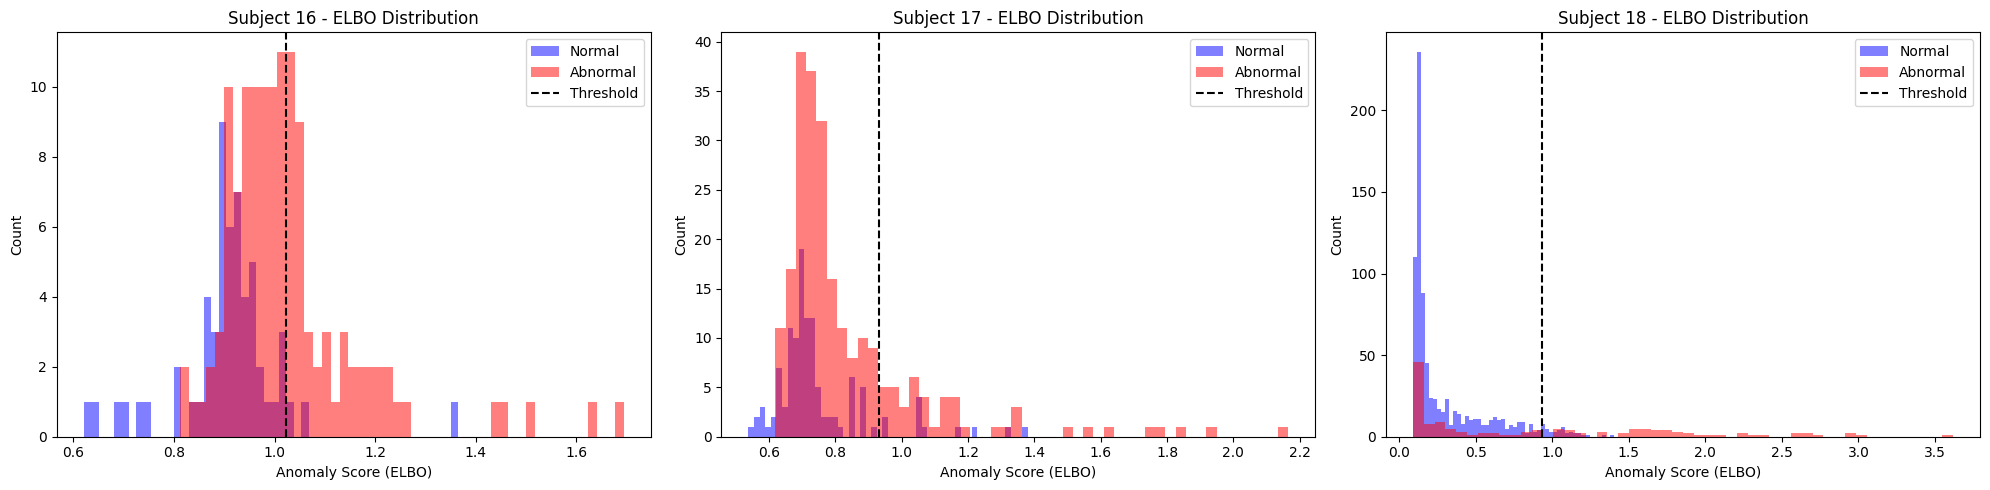

In [42]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
plt.hist(normal_scores_16, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_16, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_16 = np.percentile(normal_scores_16, 95)
plt.axvline(threshold_16, color='black', linestyle='--', label='Threshold')
plt.title('Subject 16 - ELBO Distribution')
plt.xlabel('Anomaly Score (ELBO)')
plt.ylabel('Count')
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
plt.hist(normal_scores_17, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_17, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_17 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_17, color='black', linestyle='--', label='Threshold')
plt.title('Subject 17 - ELBO Distribution')
plt.xlabel('Anomaly Score (ELBO)')
plt.ylabel('Count')
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
plt.hist(normal_scores_18, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_18, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_18 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_18, color='black', linestyle='--', label='Threshold')
plt.title('Subject 18 - ELBO Distribution')
plt.xlabel('Anomaly Score (ELBO)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
def create_error_df(normal_scores, abnormal_scores):
    return pd.DataFrame({
        'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
        'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
    })

error_df_16 = create_error_df(normal_scores_16, abnormal_scores_16)
error_df_17 = create_error_df(normal_scores_17, abnormal_scores_17)
error_df_18 = create_error_df(normal_scores_18, abnormal_scores_18)

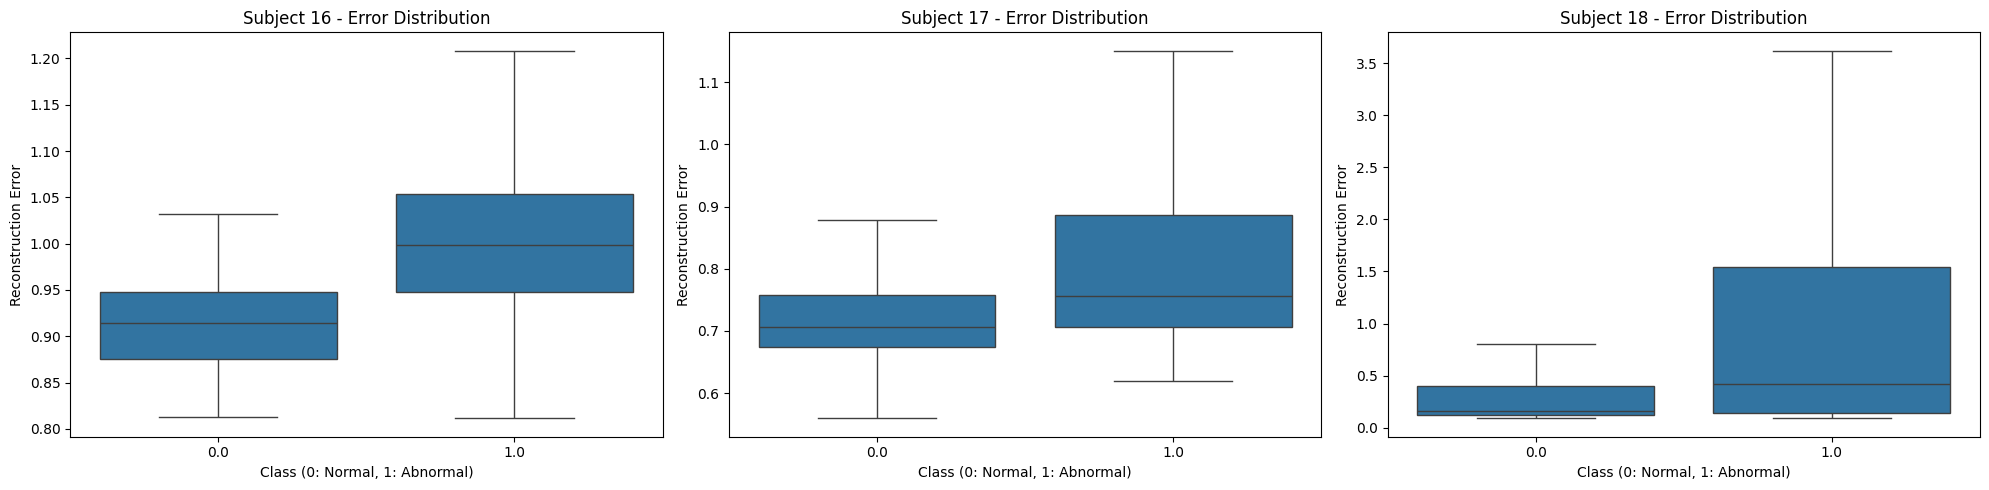

In [45]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_16, showfliers=False)
plt.title('Subject 16 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 2)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_17, showfliers=False)
plt.title('Subject 17 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 3)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_18, showfliers=False)
plt.title('Subject 18 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.tight_layout()
plt.show()

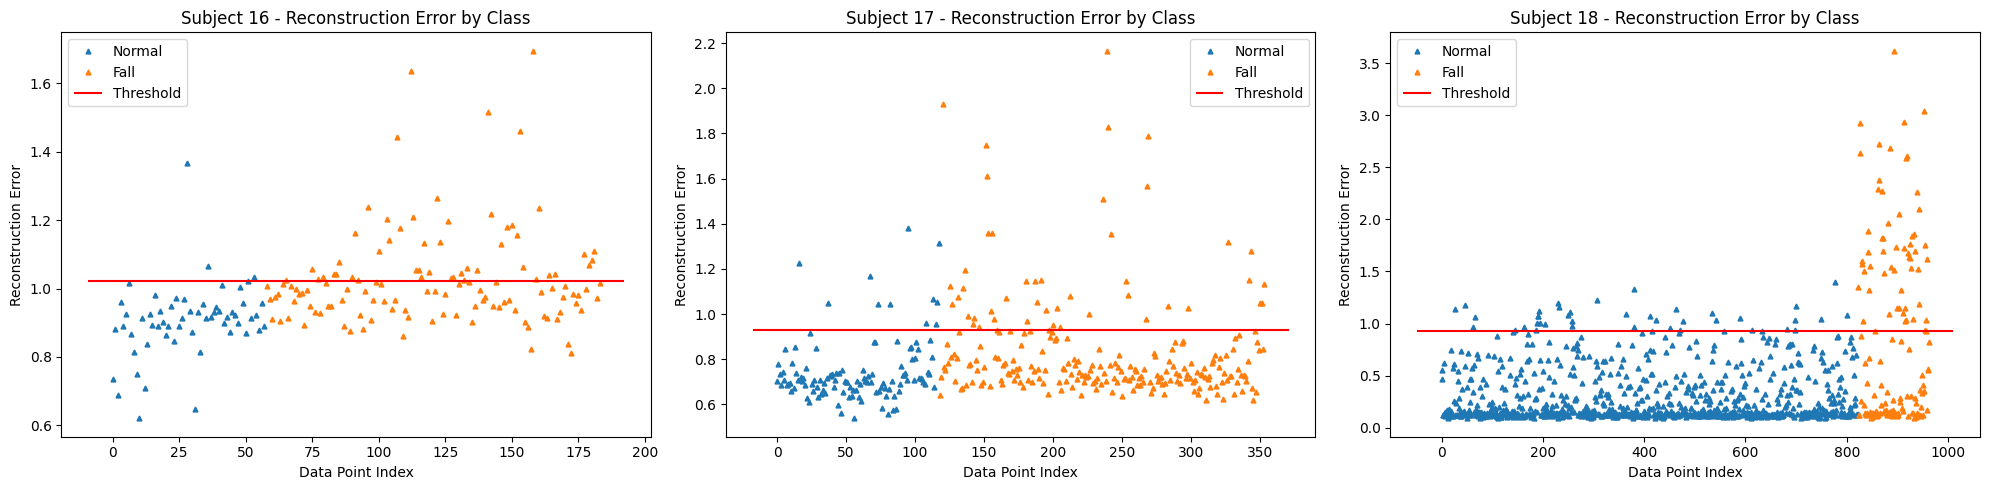

In [46]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
groups = error_df_16.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_16, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 16 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
groups = error_df_17.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_17, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 17 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
groups = error_df_18.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_18, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 18 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

plt.tight_layout()
plt.show()

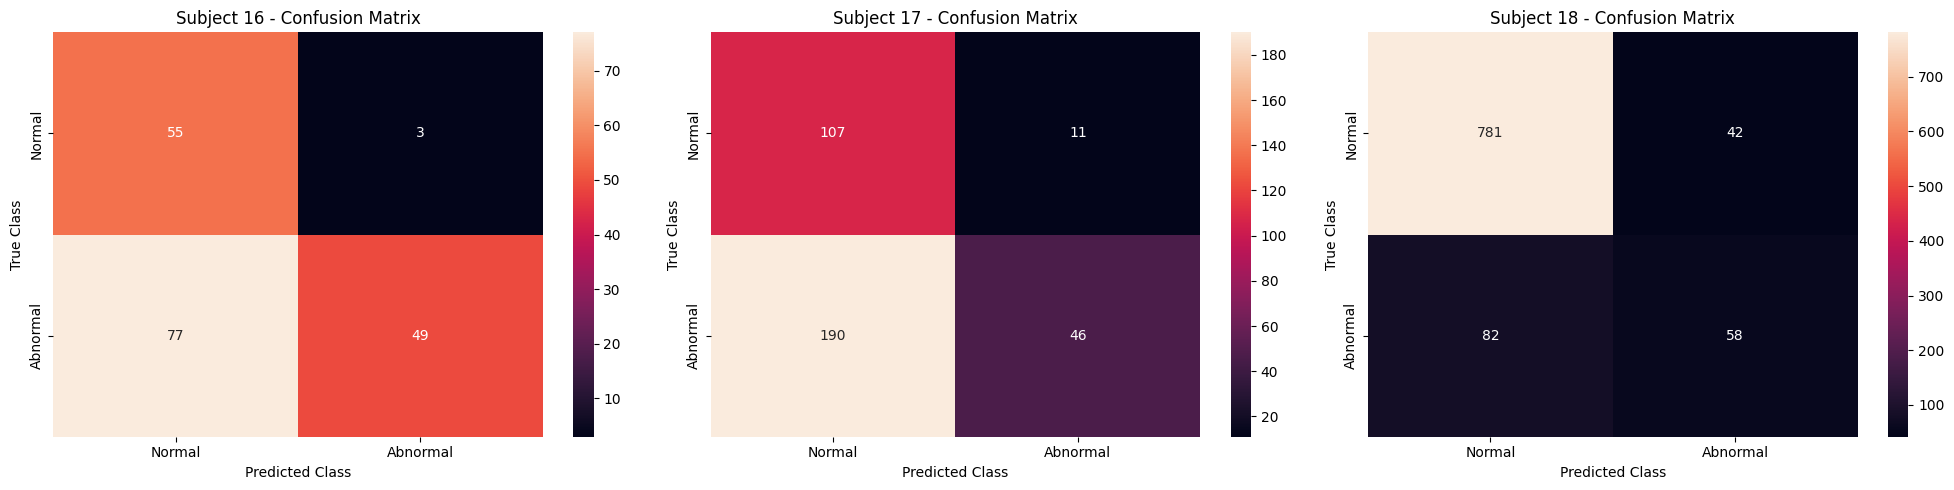

In [47]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
y_pred_16 = [1 if e > threshold_16 else 0 for e in error_df_16.reconstruction_error.values]
conf_matrix_16 = confusion_matrix(error_df_16.true_class, y_pred_16)
sns.heatmap(conf_matrix_16, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 16 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 17
plt.subplot(1, 3, 2)
y_pred_17 = [1 if e > threshold_17 else 0 for e in error_df_17.reconstruction_error.values]
conf_matrix_17 = confusion_matrix(error_df_17.true_class, y_pred_17)
sns.heatmap(conf_matrix_17, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 17 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 18
plt.subplot(1, 3, 3)
y_pred_18 = [1 if e > threshold_18 else 0 for e in error_df_18.reconstruction_error.values]
conf_matrix_18 = confusion_matrix(error_df_18.true_class, y_pred_18)
sns.heatmap(conf_matrix_18, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 18 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

In [48]:
for subject_id, error_df, threshold in [
    (16, error_df_16, threshold_16),
    (17, error_df_17, threshold_17),
    (18, error_df_18, threshold_18)
]:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    y_true = error_df.true_class.values
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'\nSubject {subject_id} Performance:')
    print(f'Accuracy Score : {accuracy:.4f}')
    print(f'Precision     : {precision:.4f}')
    print(f'Recall        : {recall:.4f}')
    print(f'F1 Score      : {f1:.4f}')


Subject 16 Performance:
Accuracy Score : 0.5652
Precision     : 0.9423
Recall        : 0.3889
F1 Score      : 0.5506

Subject 17 Performance:
Accuracy Score : 0.4322
Precision     : 0.8070
Recall        : 0.1949
F1 Score      : 0.3140

Subject 18 Performance:
Accuracy Score : 0.8712
Precision     : 0.5800
Recall        : 0.4143
F1 Score      : 0.4833
